## Let's start building a model for stock performance by trying to predict (in a vacuum, using just the previous history) the future behavior of a single stock.

In the future, I'll want to combine this in a neural net with many other stocks, labeled by their sector and/or industry (via one-hot encoding), log market cap, and maybe the exchange, to improve predictions.  

For now though, let's just try putting together a relatively simple VARMAX model on a single stock.

My primary variable is going to be the fractional change in the adjusted closing price, since I can unwind that to get the actual change if need be, then I'll feed in a few other time series as exogenous (covariate) variables.

I'm going to do this with a simple artificial neural net using the keras framework.

In [2]:
# imports:
import os
import re
import time
import tqdm
import urllib.request
import pandas as pd
import seaborn as sns
import numpy as np
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

%matplotlib inline

Using TensorFlow backend.


In [3]:
# setting some over-arching variables, including my API key for later

datatype = 'csv'

figsize = (11, 6)

root_dir = os.path.expanduser('~')+'/projects/stocks/'
stock_dir = root_dir + '/symbols/'
master_fname = root_dir + 'reduced_data.csv'

symbol_fname = lambda symbol:  stock_dir+symbol+'.'+datatype

# api key for alphavantage should be stored as 
# plaintext in a non-checked-in one-line text file 
with open(root_dir+'alpha_api_key') as f:
    apikey = f.readline().strip()

Step 1, of course, is getting data.  I'm going to make use of AlphAdvantage's public API, which allows you to download historical data for a given stock symbol.

That presents another problem, though, which is getting lists of stock symbols.  While I know a few off the top of my head, my long-term goal is going to require thousands problably, and I'll want to gather some extra data for each symbol as well.  

Fortunately, I discovered that the NASDAQ has a downloadable CSV file for three diffrerent exchanges that provides much of the data that I could want, so let's start with those.

Having downloaded those three files, I'm going to load them up and sanitize them to create a list of stock symbols:

#### Loading up the list of stock symbols:

In [4]:
def load_symbols_in_one_exchange(exchange, df=None):
    """
    load and sanitize the list of symbols in one exchange
    
    optionally appends the resultant dataframe to an existing df
    
    Args:
        exchange (string):  either 'nasdaq', 'amex', or 'nyse'
                            to load the symbol list corresponding
                            to that exchange
                            
        df (dataframe):  an existing pandas dataframe to append to
    
    Returns:
        pandas dataframe with the cleaned data from the appropriate
        CSV file
    """
    
    assert exchange in ['nasdaq', 'amex', 'nyse']
    this_df = pd.read_csv(root_dir+'companylist_{}.csv'.format(exchange))

    #now sanitize the data...
    if exchange == 'nasdaq':
        this_df = this_df.drop(columns='ADR TSO')

    else:
        # have to convert the market cap into a number
        this_df['MarketCap'] = this_df['MarketCap'].apply(lambda x:
            float(x.replace('M', 'e6').replace('B', 'e9').strip('$')) if pd.notnull(x)
            else np.nan)

        # also have to capitalize industry column name
        this_df = this_df.rename({'industry':'Industry'}, axis='columns')

    # store the exchange:
    this_df['Exchange'] = exchange

    # replace NaNs in the sectors...
    this_df['Sector'] = this_df['Sector'].apply(lambda x:  x if pd.notnull(x) else 'Unknown')

    unnamed_keys = [k for k in this_df.keys() if k.startswith('Unnamed')]
    for k in unnamed_keys:
        if np.isfinite(this_df[k]).any():
            raise IOError("Got an unnamed column with data")
        else:
            this_df = this_df.drop(columns=k)

    # may need to alter symbol depending on the exchange, since there can be dupes...
    # don't seem to be running across this problem though

    if df is None:
        return this_df
    else:
        return df.append(this_df, ignore_index=True)
    
def load_full_symbol_list(reorder=True):
    """
    load, sanitize, and (optionally) reorder the full list of symbols
    """
    symbol_list = None
    for exchange in ['nasdaq', 'amex', 'nyse']:
        symbol_list = load_symbols_in_one_exchange(exchange, symbol_list)

    if reorder:
        # randomly re-order the list:
        symbol_list = symbol_list.reindex(np.random.permutation(symbol_list.index))

    # drop the first instance of the 12 symbols that are listed in two exchanges
    symbol_list.drop_duplicates('Symbol', inplace=True)

    # select symbols that are not "preferred stocks", 
    # since I can't figure out how to grab those via alphavantage's API
    symbol_list = symbol_list.loc[symbol_list['Symbol'].map(lambda x:  '^' not in x)]

    # clean up any white space, cause that shouldn't exist in any of them
    symbol_list['Symbol'] = symbol_list['Symbol'].apply(lambda x: x.strip())

    return symbol_list


symbol_list = load_full_symbol_list()

Take a look at that table to see what type of data it contains:

In [5]:
symbol_list.head()

,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,Industry,Summary Quote,Exchange
746,CNCE,"Concert Pharmaceuticals, Inc.",10.26,2.414101e+08,2014.0,Health Care,Major Pharmaceuticals,https://www.nasdaq.com/symbol/cnce,nasdaq
6812,HYI,Western Asset High Yield Defined Opportunity F...,15.05,3.428900e+08,2010.0,Unknown,NaN,https://www.nasdaq.com/symbol/hyi,nyse
3780,WUBA,58.com Inc.,71.12,1.054000e+10,2013.0,Technology,"Computer Software: Programming, Data Processing",https://www.nasdaq.com/symbol/wuba,nyse
1730,IRTC,"iRhythm Technologies, Inc.",71.77,1.755750e+09,2016.0,Health Care,Medical/Dental Instruments,https://www.nasdaq.com/symbol/irtc,nasdaq
6632,USB,U.S. Bancorp,49.22,7.876000e+10,NaN,Finance,Major Banks,https://www.nasdaq.com/symbol/usb,nyse


Most important for us right now is just the symbol, which we can use to query the AlphAdvantage API.  Let's pick a stock that had a relatively early IPO year, since we can expect to have a lot of historical data for it.

In [6]:
symbol_list.loc[symbol_list['IPOyear'] < 1980]

,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,Industry,Summary Quote,Exchange
223,AMAT,"Applied Materials, Inc.",42.01,3.988398e+10,1972.0,Technology,Semiconductors,https://www.nasdaq.com/symbol/amat,nasdaq
3358,WDFC,WD-40 Company,172.34,2.382487e+09,1973.0,Basic Industries,Major Chemicals,https://www.nasdaq.com/symbol/wdfc,nasdaq
704,COKE,"Coca-Cola Consolidated, Inc.",291.62,2.082589e+09,1972.0,Consumer Non-Durables,Beverages (Production/Distribution),https://www.nasdaq.com/symbol/coke,nasdaq


Great, let's work with Coke data, which should go pretty far back (not super surprising!)

In [7]:
symbol = 'COKE'

#### Download data for a symbol from AlphAdvantage:

In [8]:
def download_symbol(symbol, function='TIME_SERIES_WEEKLY_ADJUSTED'):
    """
    save historical data for a stock symbol to a local CSV file
    
    Args:
        symbol (string):  stock symbol to download from alphadvantage
        function (string):  function to query.  see the alphadvantage
                            API documentation at 
                            https://www.alphavantage.co/documentation/
                            for a list of valid functions and what they
                            return
    """
    url = ('https://www.alphavantage.co/query?function={}&symbol={}&apikey={}&datatype={}'.format(
            function, symbol, apikey, datatype))

    if not os.path.isfile(symbol_fname(symbol)):
        urllib.request.urlretrieve(url, symbol_fname(symbol))  
    
download_symbol(symbol)

### Start with some exploratory analysis of the stock data to make sure it looks like what we expect

In [9]:
# read the CSV file into a dataframe and parse the timestamp column as a date
stock_performance = pd.read_csv(
    symbol_fname(symbol), parse_dates=['timestamp'],
    index_col='timestamp')

In [10]:
stock_performance.describe()

,open,high,low,close,adjusted close,volume,dividend amount
count,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1.111000e+03,1111.000000
mean,79.237944,81.593205,76.899294,79.361468,72.314894,1.125502e+05,0.019127
std,51.856028,53.926716,50.270135,52.307098,55.057639,1.204467e+05,0.066482
min,32.890000,34.350000,31.410000,32.750000,25.186500,7.100000e+03,0.000000
25%,50.545000,51.615000,49.200000,50.310000,40.401700,4.660000e+04,0.000000
50%,57.500000,58.990000,56.000000,57.270000,48.331400,7.860000e+04,0.000000
75%,70.735000,72.860000,68.700000,70.805000,67.148500,1.339790e+05,0.000000
max,295.840000,302.710000,289.990000,302.090000,302.090000,1.553863e+06,0.250000


So we have 1111 datapoints, which comes out to 1111/52 $\simeq$ 21 years.  Not actually as far back as we'd expect (1973 is now 46 years ago), so presumably we're hitting a limitation of the AlphAdvantage (free) API.  This should still be long enough to do something interesting though.

Let's also store the timestamp as a column (as well as the index)

In [11]:
stock_performance['timestamp'] = stock_performance.index

##### Let's make some simple plots:

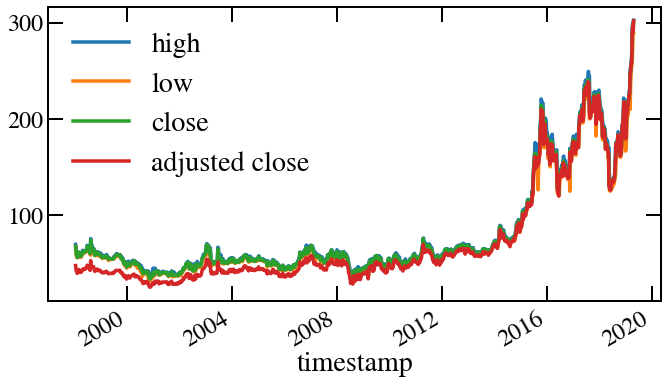

In [12]:
stock_performance.plot(y=['high', 'low', 'close', 'adjusted close'], figsize=figsize)

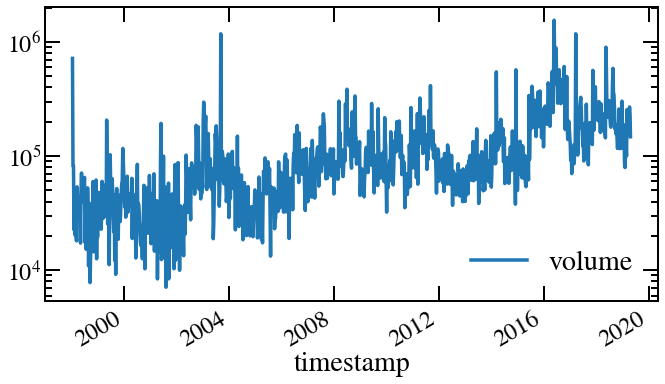

In [13]:
ax = stock_performance.plot(y=['volume'], figsize=figsize)
ax.set_yscale('log')

Clearly none of these quantities are stationary, so let's do differencing to level them out:

In [14]:
change = stock_performance - stock_performance.shift()
new_name_dict = dict([(k, 'delta '+k) for k in change])
change.rename(columns=new_name_dict, inplace=True)

In [15]:
change.describe()

,delta open,delta high,delta low,delta close,delta adjusted close,delta volume,delta dividend amount,delta timestamp
count,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1.110000e+03,1110.000000,1110
mean,-0.199441,-0.209874,-0.199550,-0.211342,-0.229174,5.149162e+02,0.000000,-7 days +00:01:17.837837
std,4.466713,3.954570,4.439233,4.418638,4.273949,1.055394e+05,0.097881,0 days 07:14:33.943455
min,-30.070000,-26.527600,-37.689000,-28.580000,-28.580000,-1.064800e+06,-0.250000,-11 days +00:00:00
25%,-1.330000,-0.967500,-1.147500,-1.287500,-1.133925,-2.067325e+04,0.000000,-7 days +00:00:00
50%,-0.015000,0.000000,-0.110000,-0.060000,-0.056600,3.880000e+02,0.000000,-7 days +00:00:00
75%,1.200000,0.857500,0.837500,1.130000,0.924475,2.376600e+04,0.000000,-7 days +00:00:00
max,33.990000,38.151500,37.990000,34.020000,33.868300,1.066500e+06,0.250000,-3 days +00:00:00


##### Again, make some simple plots:

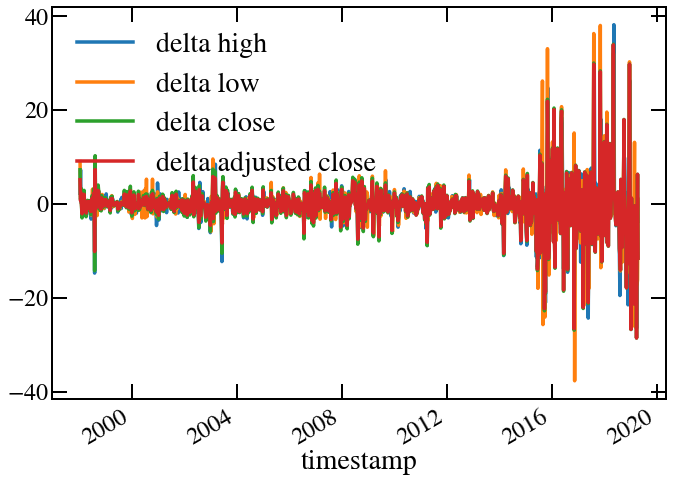

In [16]:
change.plot(y=['delta high', 'delta low', 'delta close', 'delta adjusted close'], figsize=(11, 8))

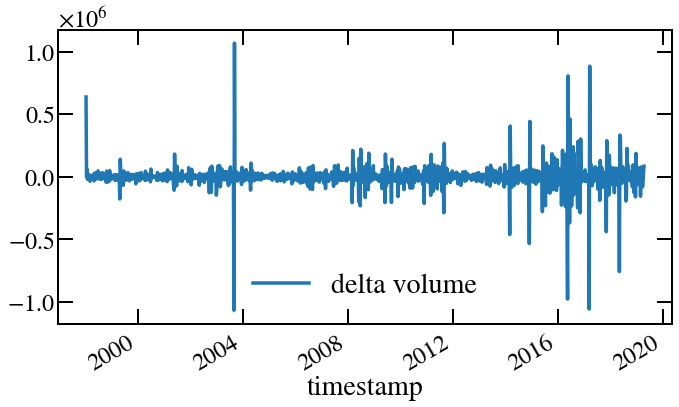

In [17]:
ax = change.plot(y=['delta volume'], figsize=figsize)

There are pretty huge deviations in the change in the volume of trading that we'll want to be careful of, but those could also be important.  We might want to just encode whether a trading week had an unusually high volume or not, rather than the actual volume.

We can also see that the changes in the price get higher at later times, which is in large part due to just the price going up as a whole.  Let's level that out by looking at fractional changes, instead of total changes.

In [18]:
fractional_change = pd.DataFrame()
fractional_change['timestamp'] = stock_performance.index
fractional_change.set_index('timestamp', inplace=True)

keys = ['high', 'low', 'close', 'adjusted close', 'volume']
fdel_prefix = 'frac delta '
fdel_keys = [fdel_prefix + k for k in keys]
for key in keys:
    fractional_change[fdel_prefix+key] = (
        change['delta '+key]/stock_performance[key])

And again, some simple plots to see how those look:

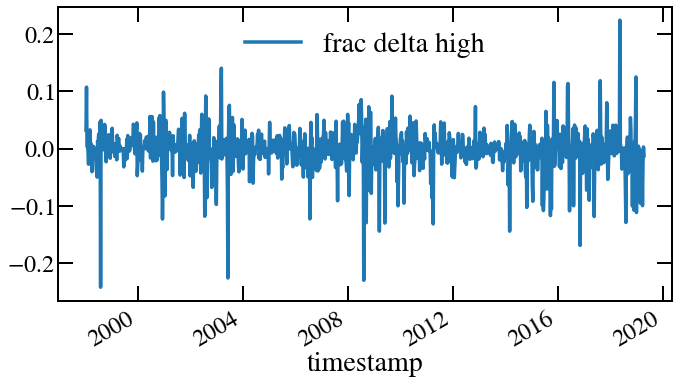

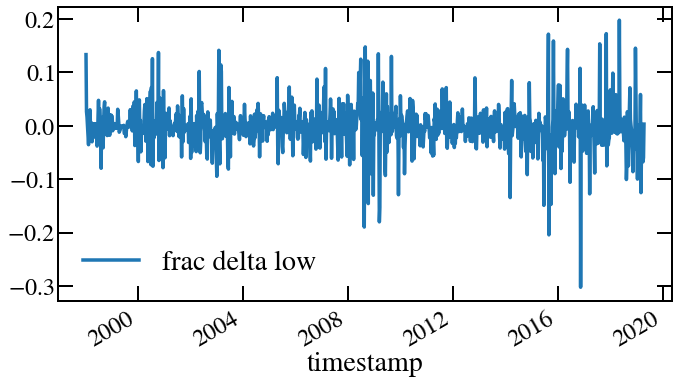

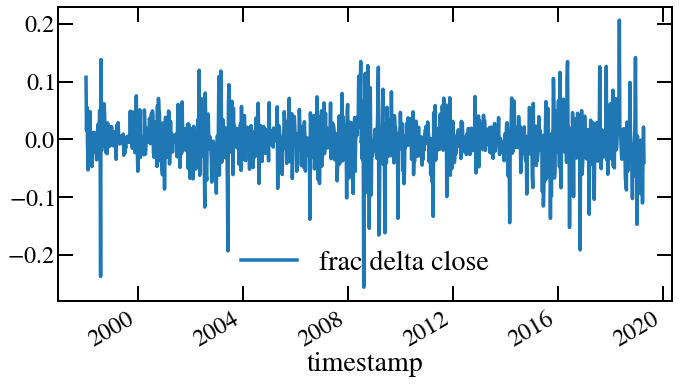

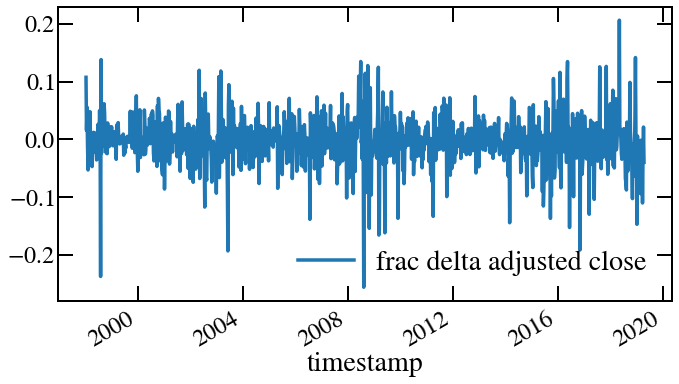

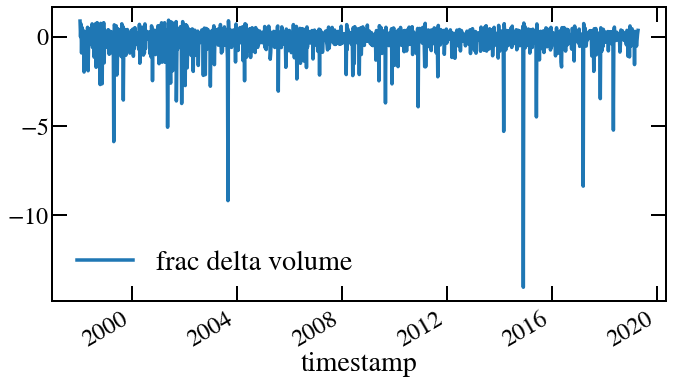

In [19]:
for k in ['high', 'low', 'close', 'adjusted close', 'volume']:
    fractional_change.plot(y=fdel_prefix+k, figsize=figsize)

I'm also hypothesizing that the difference between the high and the low could be informative, so let's make sure that's relatively stable:

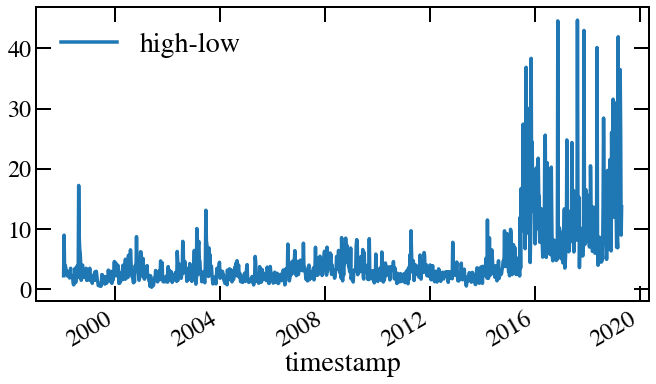

In [20]:
stock_performance['high-low'] = stock_performance['high'] - stock_performance['low']
stock_performance.plot(y='high-low', figsize=figsize)

Hmm, so this again is not stationary and exhibits huge swings due to the overall growth at late times.  Let's try the same trick and normalize by the close.

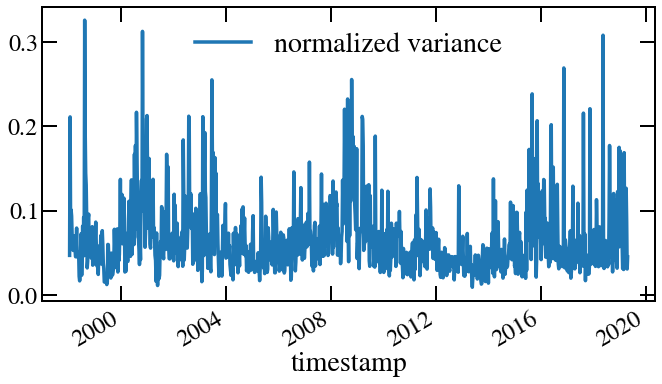

In [21]:
stock_performance['normalized variance'] = stock_performance['high-low']/stock_performance['adjusted close']
stock_performance.plot(y='normalized variance', figsize=figsize)

That looks much better!

##### Let's summarize what I'e done in the section above with a function to transform the loaded data for a single symbol into the time series I'm interested in

In [40]:
def load_symbol_data(symbol, symbol_list, resample=None):
    """
    load and transform time series data for a single stock symbol
    
    also adds on some metadata columns from the overarching symbol list
    
    Args:
        symbol (string):  stock symbol to load
        symbol_list (dataframe):  dataframe with metadata information for
                                  at least this symbol
    
    Returns:
        a dataframe, indexed by timestamp, with the following columns:
            * fractional change in volume
            * fractional change in adjusted close
            * fractional change in adjusted high
            * normalized difference between high and low in a given time period    
            * date (for ease of use with some applications)
            * time period over which the changes are defined
    """
    # get the sector, market cap, exchange, and industry from the symbol_list
    symbol_row = symbol_list.loc[symbol_list['Symbol'] == symbol]

    # make sure we have data for this symbol:
    download_symbol(symbol)
    
    # load the information for a single symbol and index it by the date
    date_column_name = 'timestamp'
    stock_performance = pd.read_csv(symbol_fname(symbol), 
        parse_dates=[date_column_name], index_col=date_column_name)
    
    if resample is not None:
        ## per work below, it seems like we're doing a terrible job at predicting weekly behavior. 
        ## maybe we can do better if we resample though?
        stock_performance = stock_performance.resample(resample).mean()

    stock_performance['date'] = stock_performance.index
   
    # get the total change in each column over a 1 week period
    change = stock_performance - stock_performance.shift()
    new_name_dict = dict([(k, 'delta '+k) for k in change])
    change.rename(columns=new_name_dict, inplace=True)
    
    # create a new dataframe to store the output numbers we care about
    fractional_change = pd.DataFrame()
    fractional_change['timestamp'] = stock_performance.index
    fractional_change.set_index('timestamp', inplace=True)

    # store the amount of time over which the deltas are computed
    fractional_change['delta time'] = change['delta date']
    
    # store the actual date of each observation
    fractional_change['date'] = stock_performance['date']
    
    # copy over the raw closing value for the purpose of 
    # both unwinding the fractional differencing and to try 
    # training on it directly later
    fractional_change['adjusted close'] = stock_performance['adjusted close']

    keys = ['high', 'low', 'close', 'adjusted close', 'volume']
    fdel_prefix = 'frac delta '
    fdel_keys = [fdel_prefix + k for k in keys]
    for key in keys:
        fractional_change[fdel_prefix+key] = (
            change['delta '+key]/stock_performance[key])
        
    # store the metadata -- only going to be useful when I stack a bunch 
    # of them together, which I'm not up to yet, but let's be forward 
    # thinking and include them now
    for key in ['Sector', 'MarketCap', 'Industry', 'Symbol']:
        fractional_change[key] = symbol_row[key].item()

    # store the variance within a week too 
    # (not technically a fractional variance but that's ok)
    fractional_change['normalized variance'] = (
        stock_performance['high']-stock_performance['low'])/stock_performance['adjusted close']

    # and finally, drop any rows with NaNs (will be at least 1 because of the shift)
    fractional_change.dropna(inplace=True)
    
    return fractional_change


###### And quickly test that the function gives what I expect:

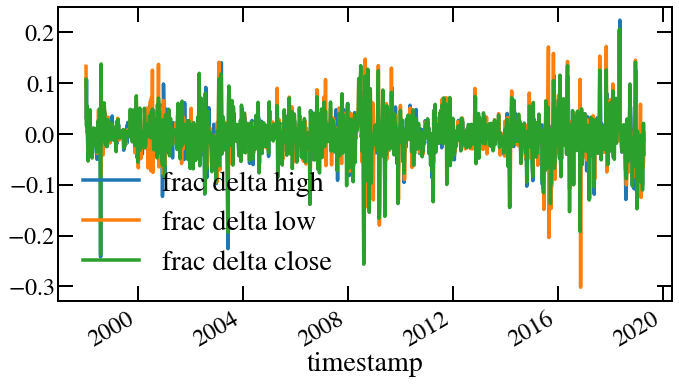

In [23]:
output = load_symbol_data(symbol, symbol_list)
output.plot(y=['frac delta high', 'frac delta low', 'frac delta close'], figsize=figsize)

Looks good!

### OK, now let's use a simple neural net to try to predict some of the late-time evolution

In [24]:
### utility functino to split the test and training sets
def split_train_test(df, frac_train, target_key, exog_keys=[]):
    """
    split a time-series dataframe into a train and test set
    
    also pulls out any secondary variables we want to train on,
    if applicable
    
    Args:
        df (dataframe):  input dataframe to split
        frac_train (float):  fraction of the dataset to 
                             use as the training set
        target_key (string):  column to train on and for
        exog_keys (list-like):  list of strings to use as 
                                as exogenous variables (i.e.
                                that might contain additional 
                                information)
    """
    df = df.sort_index()
    
    num_train = int(np.rint(len(df.index)*frac_train))
    training_date_split = df.index[num_train]
    
    training_df = pd.DataFrame(df[:training_date_split], copy=True)
    testing_df = pd.DataFrame(df[training_date_split:], copy=True)
    
    training_values = training_df.filter([target_key] + exog_keys, axis=1)
    testing_values = testing_df.filter([target_key] + exog_keys, axis=1)
    
    return training_values, testing_values

In [25]:
target_key = 'frac delta adjusted close'
training_values, test_values = split_train_test(output, 0.75, target_key)

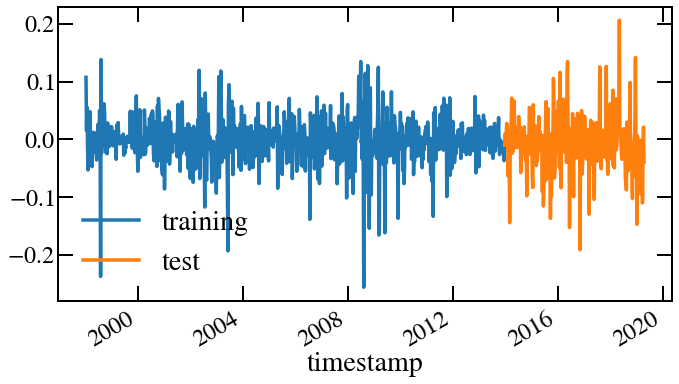

In [26]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()

training_values.plot(y=target_key, ax=ax, label='training')
test_values.plot(y=target_key, ax=ax, label='test')
ax.legend()

Optional:  Scale the data to go from -1 to 1

In [26]:
scaler = MinMaxScaler(feature_range=(-1, 1))
training_scaled = scaler.fit_transform(training_values)
test_scaled = scaler.transform(test_values)

The input is the state at $t_i$, which should provide the output at $t_{i+1}$, so X is [:-1] and y is [1:] -- 0th matches with 1st and so on

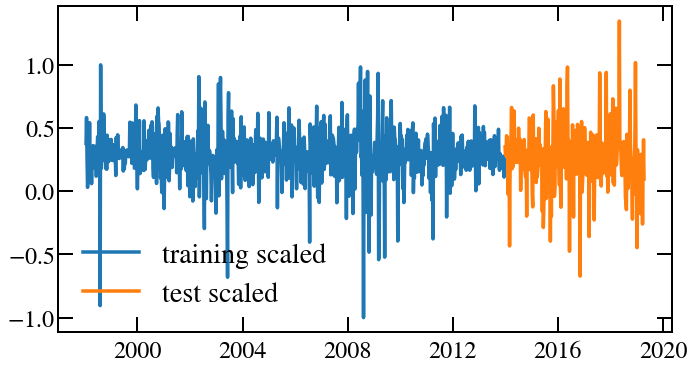

In [27]:
X_train = training_scaled[:-1]
y_train = training_scaled[1:]
X_test = test_scaled[:-1]
y_test = test_scaled[1:]

training_times = training_values.index
test_times = test_values.index

fig = plt.figure(figsize=figsize)
ax = plt.gca()
ax.plot(training_times[1:], y_train.flatten(), label='training scaled')
ax.plot(test_times[1:], y_test.flatten(), label='test scaled')
ax.legend()

Now let's create a Sequential model that takes in just one argument for the time being (just the data itself) and use RME as our loss function:

In [28]:
model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# have the model stop training early if it's not longer improving
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

# and train the model!
history = model.fit(X_train, y_train, epochs=25, batch_size=1, 
                       verbose=1, callbacks=[early_stop], shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
832/832 [==============================] - 1s 840us/step - loss: 0.0469
Epoch 2/25
832/832 [==============================] - 1s 664us/step - loss: 0.0402
Epoch 3/25
832/832 [==============================] - 1s 628us/step - loss: 0.0396
Epoch 4/25
832/832 [==============================] - 1s 653us/step - loss: 0.0395
Epoch 5/25
832/832 [==============================] - 1s 664us/step - loss: 0.0394
Epoch 6/25
832/832 [==============================] - 1s 669us/step - loss: 0.0393
Epoch 7/25
832/832 [==============================] - 1s 669us/step - loss: 0.0392
Epoch 8/25
832/832 [==============================] - 1s 682us/step - loss: 0.0392
Epoch 9/25
832/832 [==============================] - 1s 661us/step - loss: 0.0392
Epoch 10/25
832/832 [==============================] - 1s 643us/step - loss: 0.0392
Epoch 11/25
832/832 [============================

In [29]:
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

The R2 score on the Train set is:	0.007
The R2 score on the Test set is:	-0.009


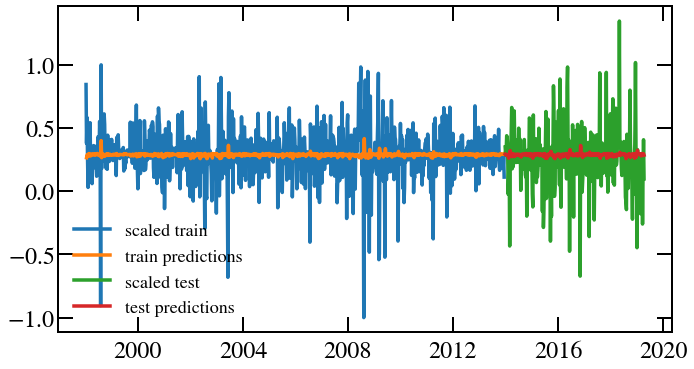

In [30]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()

training_times = training_values.index
test_times = test_values.index

# training_values.plot(y=target_key, ax=ax)
ax.plot(training_times[:-1], X_train.flatten(), label='scaled train')
ax.plot(training_times[1:], y_train_pred.flatten(), label='train predictions')
ax.plot(test_times[1:], y_test.flatten(), label='scaled test')
ax.plot(test_times[1:], y_test_pred.flatten(), label='test predictions')

ax.legend(fontsize=18)

Haha wow that's terrible!  

There's a good chance that the variance is simply too high, so maybe we're better off trying predict monthly (or even yearly) behavior.  Let's use the resampling ability built into Python to give this a try again, then we'll move on to something slightly more sophisticated.

In order to fascilitate trying different smoothings and training for different keys, let's write a function to wrap all that up:

In [30]:
def train_symbol_and_plot(symbol, symbol_list, target_key, training_fraction=0.75, 
                        resample=None, rescale=True, ):
    """
    do a simple ANN training on a single symbol.
    
    Args:
        symbol (string):  symbol to do analysis on
        symbol_list (dataframe):  metadata for the symbols
        target_key (string):  key to train on
        training_fraction (float):  fraction of points to use as training data
        resample (string):  time period to resample the data to
        rescale (bool):  whether or not to rescale the data to -1, 1
    """
    
    df = load_symbol_data(symbol, symbol_list, resample=resample)
    training_values, test_values = split_train_test(df, training_fraction, target_key)
    
    if rescale:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        training = scaler.fit_transform(training_values)
        test = scaler.transform(test_values)
    
    else:
        training = training_values[target_key].values
        test = test_values[target_key].values

    X_train = training[:-1]
    y_train = training[1:]
    X_test = test[:-1]
    y_test = test[1:]
    
    print("training on {} datapoints w/ {} as test points".format(X_train.size, X_test.size))

    training_times = training_values.index
    test_times = test_values.index

    # store the data for the purpose of checking stuff later
    data = dict(X_train=X_train,
               X_test=X_test,
               y_train=y_train,
               y_test=y_test,
               training_times=training_times,
               test_times=test_times)
    
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()

    ax.set_title('model of {}'.format(symbol), fontsize=22)
    l = ax.plot(training_times[1:], y_train.flatten(), label='training')
    ax.plot(training_times[:-1], X_train.flatten(), label='_nolegend_', color=l[-1].get_color())

    l = ax.plot(test_times[1:], y_test.flatten(), label='test')
    ax.plot(test_times[:-1], X_test.flatten(), label='_nolegend_', color=l[-1].get_color())
    
    ax.set_ylabel(target_key)
    ax.set_xlabel('time')
    
    model = Sequential()
    model.add(Dense(12, input_dim=1, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # have the model stop training early if it's not longer improving
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

    # and train the model!
    print("training model...", end='')
    history = model.fit(X_train, y_train, epochs=100, batch_size=1, 
                           verbose=0, callbacks=[early_stop], shuffle=False)
    print("done!")
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("R2 score for the training set = \t{:0.3f}".format(r2_score(y_train, y_train_pred)))
    print("R2 score for the test set = \t{:0.3f}".format(r2_score(y_test, y_test_pred)))

    ax.plot(training_times[:-1], y_train_pred, color='k', label='prediction', ls='--')
    ax.plot(test_times[:-1], y_test_pred, color='k', label='_nolegend_', ls='--')
    
    ax.legend()
    
    return model, fig, data

###### Try the same model as above to make sure we get the same thing:

training model...Epoch 00069: early stopping
done!
R2 score for the training set = 	0.018
R2 score for the test set = 	-0.035


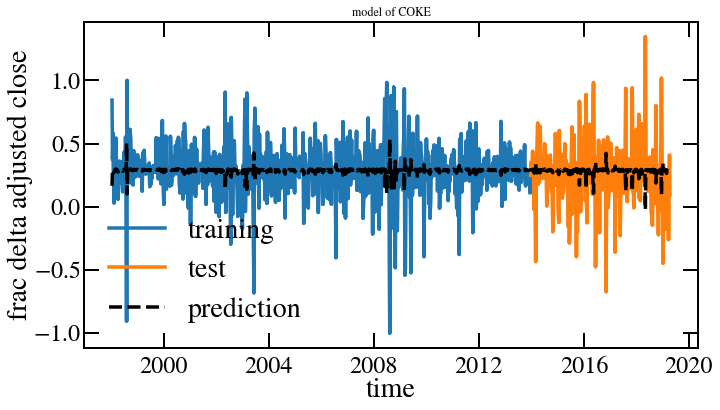

In [54]:
model, fig, data = train_symbol_and_plot(symbol, symbol_list, target_key)

###### Try a model where we smooth the inputs and take differences over longer times -- might be a bit smoother (though probably less stationary)

training model...Epoch 00084: early stopping
done!
R2 score for the training set = 	0.025
R2 score for the test set = 	-0.092


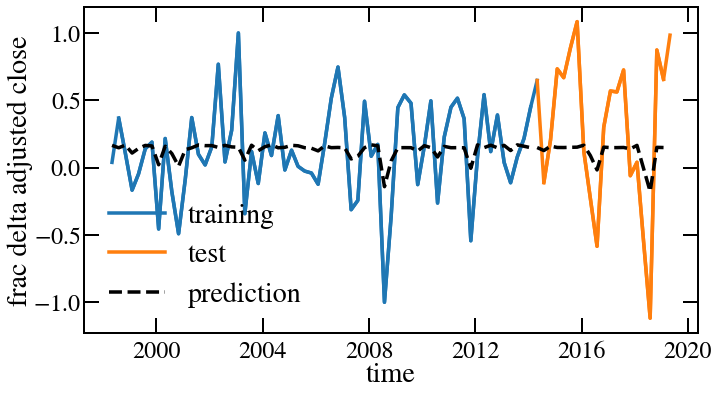

In [33]:
smoothed_model, fig, data = train_symbol_and_plot(symbol, symbol_list, target_key, resample='3M')

That's actually marginally better -- we're getting a couple of the dips, though not their magnitude for some reason still.  Not good enough to make money off of though.

###### What if we don't rescale?

training model...Epoch 00007: early stopping
done!
R2 score for the training set = 	-0.017
R2 score for the test set = 	-0.061


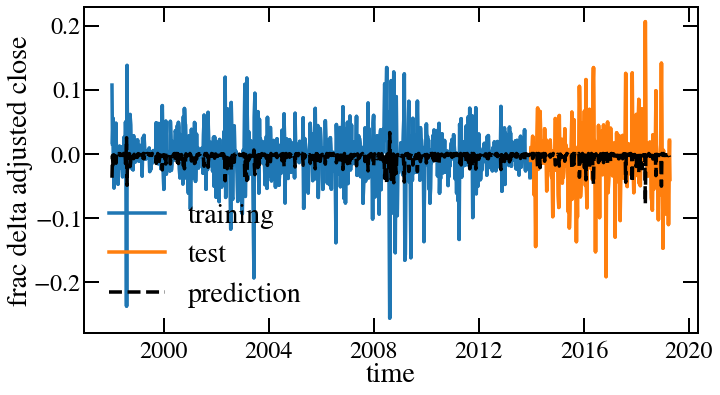

In [34]:
no_rescale_model, fig, data = train_symbol_and_plot(symbol, symbol_list, target_key, rescale=False)

###### What if we don't do the differencing or rescale?

training model...Epoch 00007: early stopping
done!
R2 score for the training set = 	0.964
R2 score for the test set = 	0.976


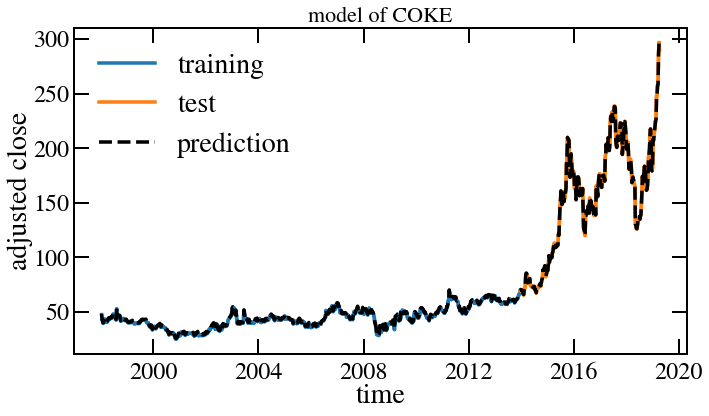

In [59]:
raw_data_model, fig, data = train_symbol_and_plot(symbol, symbol_list, 'adjusted close', rescale=False)

Wow, that actually looks fantastic!  But...let's try zooming in...

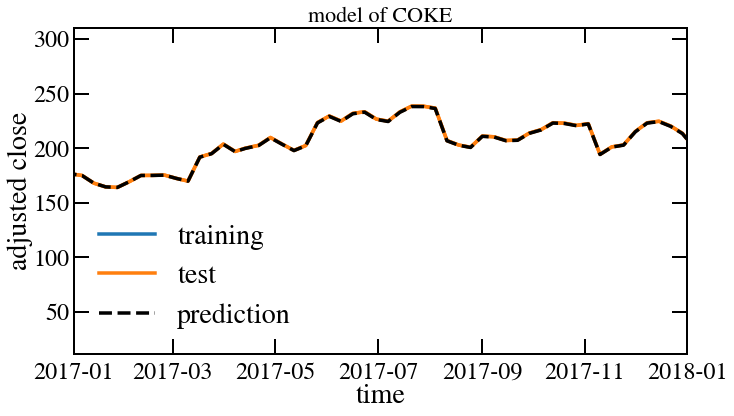

In [60]:
xlim = [datetime.date(2017, 1, 1), datetime.date(2018, 1, 1)]
fig.axes[0].set_xlim(xlim)
fig

Wow...I must have done something wrong because that looks almost too good...

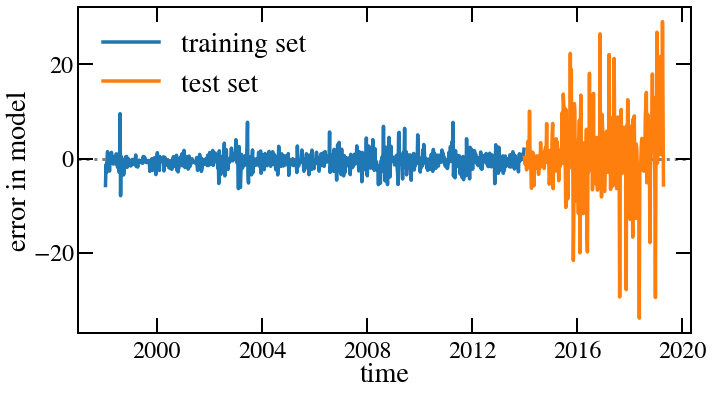

In [61]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()

train_vals = data['y_train']
train_pred_vals = raw_data_model.predict(data['X_train']).flatten()
train_diff = train_vals - train_pred_vals

ax.plot(data['training_times'][1:], train_diff, label='training set')

test_vals = data['y_test']
test_pred_vals = raw_data_model.predict(data['X_test']).flatten()
test_diff = test_vals - test_pred_vals

ax.plot(data['test_times'][1:], test_diff, label='test set')
ax.axhline(y=0, ls=':', color='grey', lw=3, zorder=0)

ax.set_xlabel('time')
ax.set_ylabel('error in model')

ax.legend();

So the errors:
    * a) aren't zero
    * b) get bigger in the test than in the training
  
Both of these facts actually give me some confidence in the model, as simple as it is.

#### Let's see if we can do this on another random symbol...

In [29]:
def plot_errors(model, data):
    """
    plot the errors in a trained model relataive to the input data
    
    Args:
        model:  a trained model with a .predict method
        data:  a dictionary with X_train, y_train, X_test, y_test,
               training_times, and test_times
               
    Returns:
        matplotlib figure
    """
    
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()

    train_pred_vals = model.predict(data['X_train']).flatten()
    train_diff = data['y_train'].flatten() - train_pred_vals

    ax.plot(data['training_times'][1:], train_diff, label='training set')

    test_pred_vals = model.predict(data['X_test']).flatten()
    test_diff = data['y_test'].flatten() - test_pred_vals

    ax.plot(data['test_times'][1:], test_diff, label='test set')

    ax.axhline(y=0, ls=':', color='grey', lw=3, zorder=0, label='_nolegend_')
    ax.set_xlabel('time')
    ax.set_ylabel('error in model')

    ax.legend()
    return fig

In [70]:
symbol_row = symbol_list.sample(n=1)
new_symbol = symbol_row['Symbol'].values[0]
symbol_row

,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,Industry,Summary Quote,Exchange
5257,NSP,"Insperity, Inc.",126.65,5.180000e+09,NaN,Technology,Professional Services,https://www.nasdaq.com/symbol/nsp,nyse


training on 832 datapoints w/ 277 as test points
training model...Epoch 00007: early stopping
done!
R2 score for the training set = 	0.968
R2 score for the test set = 	0.989


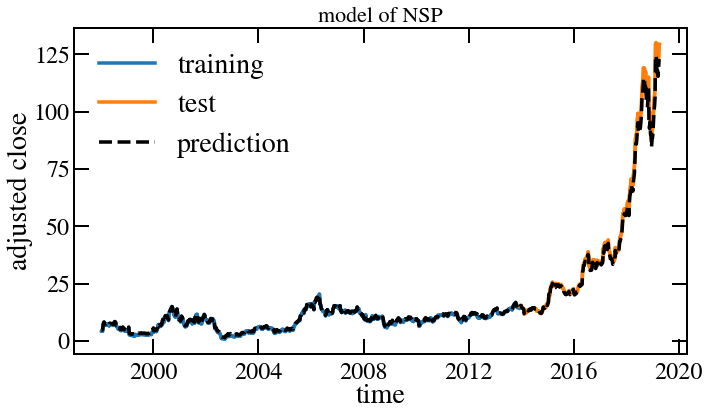

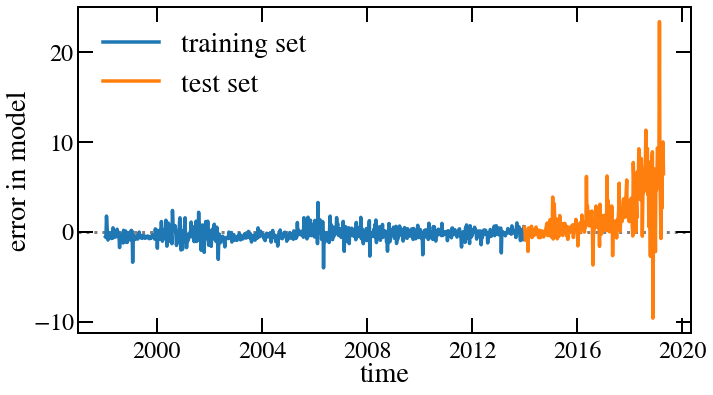

In [86]:
new_raw_data_model, fig, data = train_symbol_and_plot(new_symbol, symbol_list, 'adjusted close', rescale=False)
plot_errors(new_raw_data_model, data);

This one is slightly more worrisome because the errors are correlated in the test sample.

In [27]:
def make_plot_model_and_errors(symbol, symbol_list, target_key, **kwargs):
    """
    just a quick wrapper function to make both plots.  see the 
    functions they call for meanings of the arguments
    """
    model, fig, data = train_symbol_and_plot(symbol, symbol_list, target_key, **kwargs)
    error_fig = plot_errors(model, data)
    return model, data, fig, error_fig

def model_random_symbol(symbol_list, target_key, **kwargs):
    """
    pick a random symbol out of the symbol_list, make a model for it,
    and make some plots of it
    """
    
    symbol_row = symbol_list.sample(n=1)
    new_symbol = symbol_row['Symbol'].values[0]
    print("running a model for {}".format(new_symbol))
    return make_plot_model_and_errors(new_symbol, symbol_list, target_key, **kwargs)

First repeat for COKE, then run for a few random symbols:

training on 832 datapoints w/ 277 as test points
training model...Epoch 00007: early stopping
done!
R2 score for the training set = 	0.963
R2 score for the test set = 	0.976


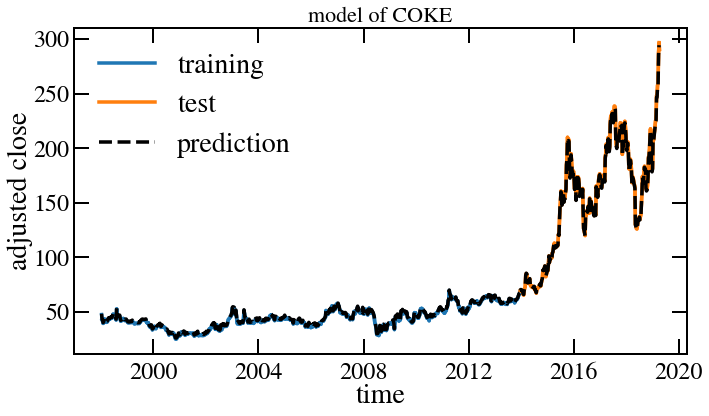

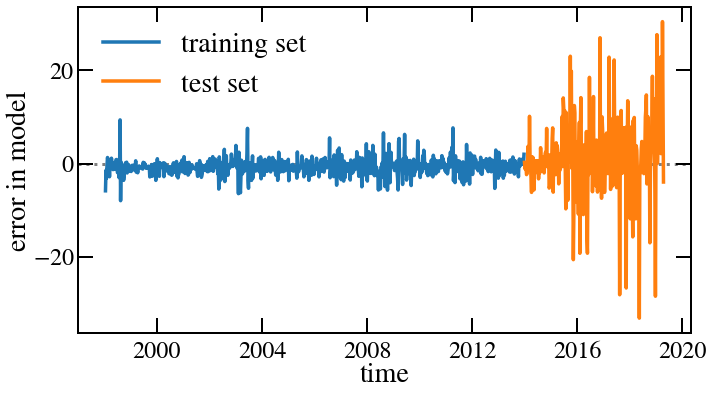

In [32]:
model, data, fig, error_fig = make_plot_model_and_errors('COKE', symbol_list, 'adjusted close', rescale=False)

running a model for BBT
training on 832 datapoints w/ 277 as test points
training model...Epoch 00007: early stopping
done!
R2 score for the training set = 	0.954
R2 score for the test set = 	0.970


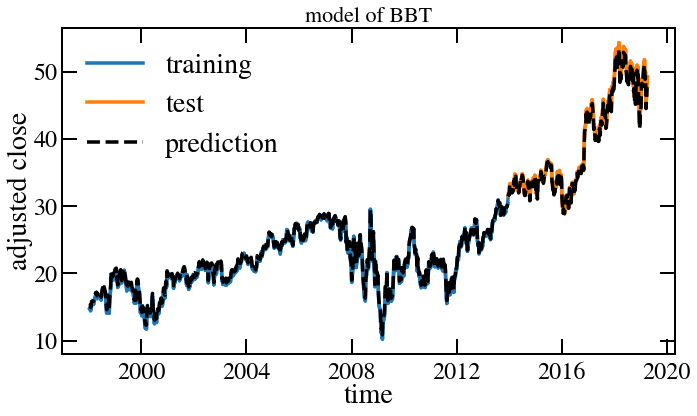

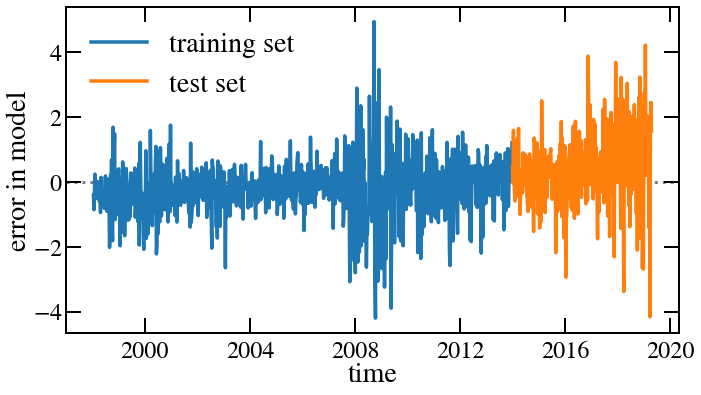

In [97]:
model, data, fig, error_fig = model_random_symbol(symbol_list, 'adjusted close', rescale=False)

running a model for GMO
training on 553 datapoints w/ 183 as test points
training model...Epoch 00069: early stopping
done!
R2 score for the training set = 	0.957
R2 score for the test set = 	0.272


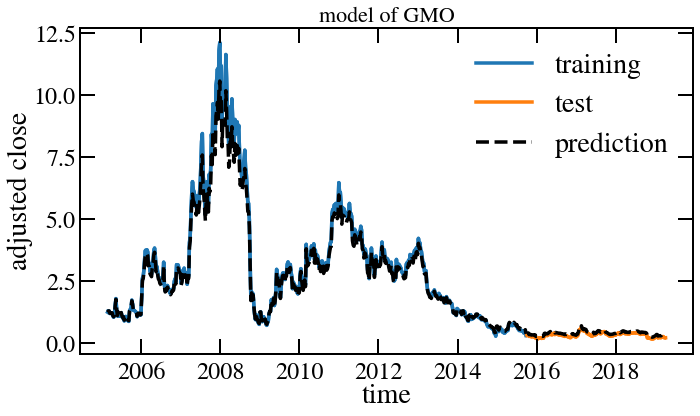

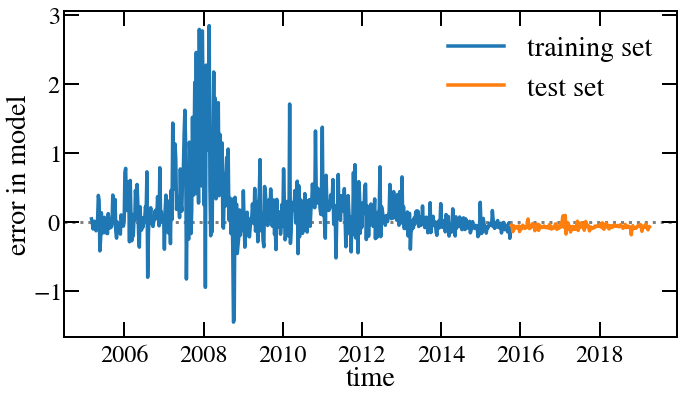

In [100]:
model, data, fig, error_fig = model_random_symbol(symbol_list, 'adjusted close', rescale=False)

running a model for UBCP
training on 832 datapoints w/ 276 as test points
training model...Epoch 00010: early stopping
done!
R2 score for the training set = 	0.923
R2 score for the test set = 	0.880


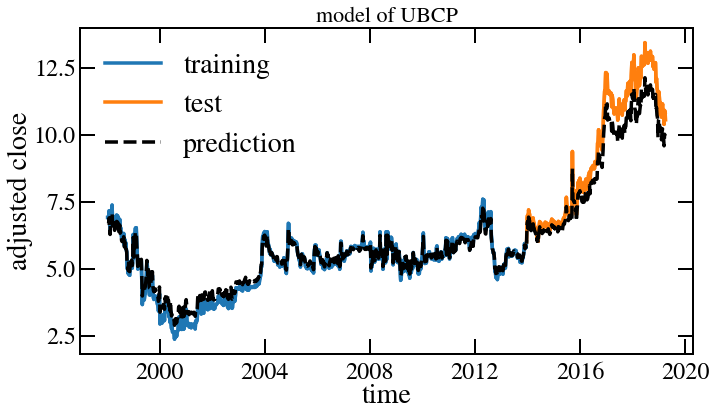

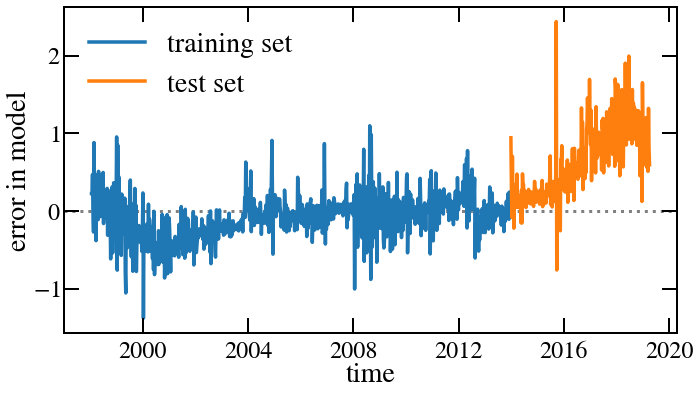

In [99]:
model, data, fig, error_fig = model_random_symbol(symbol_list, 'adjusted close', rescale=False)

running a model for PLYA
training on 85 datapoints w/ 27 as test points
training model...Epoch 00009: early stopping
done!
R2 score for the training set = 	0.590
R2 score for the test set = 	0.746


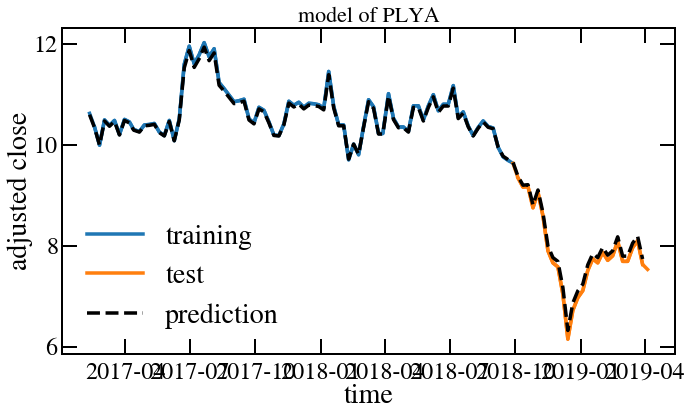

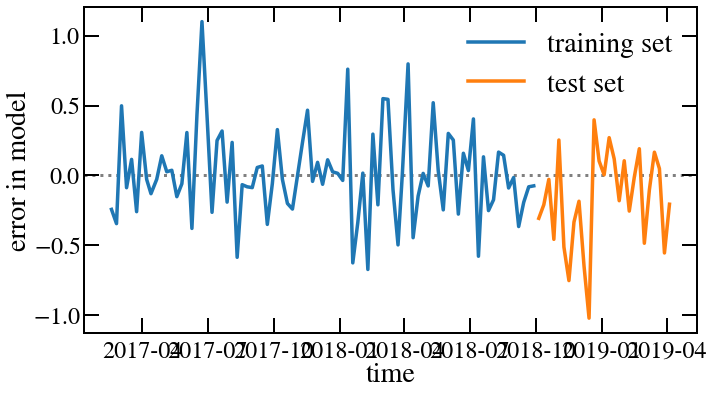

In [102]:
model, data, fig, error_fig = model_random_symbol(symbol_list, 'adjusted close', rescale=False)

running a model for VSAT
training on 832 datapoints w/ 277 as test points
training model...done!
R2 score for the training set = 	0.982
R2 score for the test set = 	0.802


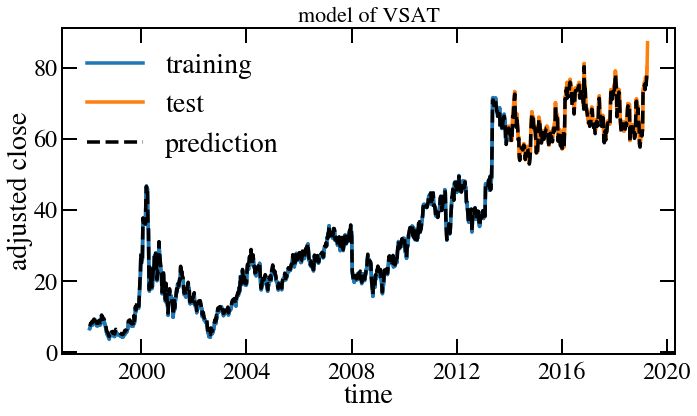

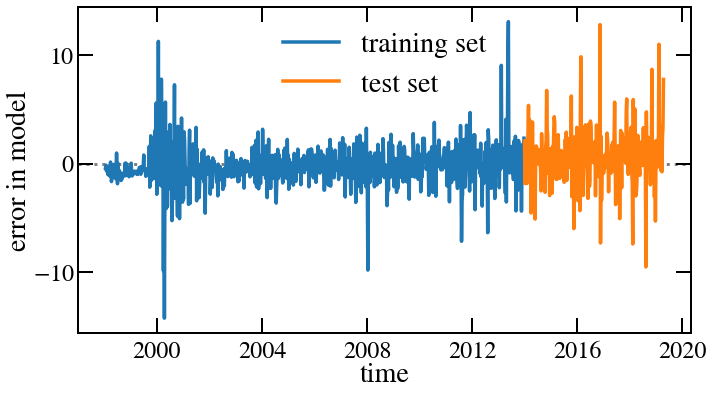

In [104]:
model, data, fig, error_fig = model_random_symbol(symbol_list, 'adjusted close', rescale=False)

So clearly this model, while not necessarily awful, is highly imperfect.  We could probably get it to do better by training all the way up to the last few weeks, make sure that it did ok in the last two weeks, then predict the behavior over the next week or two -- that would probably be good enough to actually make a bit of money on the stock market, combined with a bit of luck especially.  

Let's see if we can do better with a more sophisticated neural network though, an LSTM RNN

### Now let's compare with an LSTM RNN:

In [33]:
# reset back to a symbol with good history
symbol = 'COKE'

First we have to massage the normalized data into the matrices that LSTM is expecting:

In [36]:
def train_lstm_symbol_and_plot(symbol, symbol_list, target_key, 
                               training_fraction=0.75, resample=None, 
                               rescale=True, num_neurons=10):
    """
    train an LSTM RNN on a single symbol and plot the results
    
    Args:
        symbol (string):  symbol to do analysis on
        symbol_list (dataframe):  metadata for the symbols
        target_key (string):  key to train on
        training_fraction (float):  fraction of points to use as training data
        resample (string):  time period to resample the data to
        rescale (bool):  whether or not to rescale the data to -1, 1
    """
    
    df = load_symbol_data(symbol, symbol_list, resample=resample)
    training_values, test_values = split_train_test(df, training_fraction, target_key)
    
    training_times = training_values.index
    test_times = test_values.index
    
    if rescale:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        training = scaler.fit_transform(training_values)
        test = scaler.transform(test_values)
    
        training_df = pd.DataFrame(
            training, columns=['Y'], index=training_values.index)
        
        test_df = pd.DataFrame(
            test, columns=['Y'], index=test_values.index)
    
    else:
        training_df = deepcopy(training_values)
        test_df = deepcopy(test_values)
        
    training_values['X_1'] = training_values[target_key].shift()
    test_values['X_1'] = test_values[target_key].shift()

    # drop the rows that don't have data because we shifted them away
    # then pop out the columns that we're going to train on and for
    X_train = training_values.dropna().drop(target_key, axis=1)
    y_train = training_values.dropna().drop('X_1', axis=1)

    X_test = test_values.dropna().drop(target_key, axis=1)
    y_test = test_values.dropna().drop('X_1', axis=1)

    # convert these to matrices
    X_train = X_train.values
    y_train = y_train.values

    X_test = X_test.values
    y_test = y_test.values

    # reshape into tensors
    X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    print("training on {} datapoints w/ {} as test points".format(X_train.shape[0], X_test.shape[0]))
    
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()

    ax.set_title('LSTM model of {}'.format(symbol), fontsize=22)
    
    l = ax.plot(training_times[1:], y_train.flatten(), label='training')
    ax.plot(training_times[:-1], X_train.flatten(), label='_nolegend_', color=l[-1].get_color())

    l = ax.plot(test_times[1:], y_test.flatten(), label='test')
    ax.plot(test_times[:-1], X_test.flatten(), label='_nolegend_', color=l[-1].get_color())
    
    ax.set_ylabel(target_key)
    ax.set_xlabel('time')
    
    # store the data for the purpose of checking stuff later
    data = dict(X_train=X_train,
                X_test=X_test,
                y_train=y_train,
                y_test=y_test,
                X_train_lmse=X_train_lmse,
                X_test_lmse=X_test_lmse,
                training_times=training_times,
                test_times=test_times)
    
    lstm_model = Sequential()
    lstm_model.add(LSTM(num_neurons, 
                        input_shape=(1, X_train_lmse.shape[1]), 
                        activation='relu', 
                        kernel_initializer='lecun_uniform', 
                        return_sequences=False))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    
    print("training model...", end='')
    history_lstm_model = lstm_model.fit(X_train_lmse, 
                                        y_train, 
                                        epochs=100, 
                                        batch_size=1, verbose=0, 
                                        shuffle=False, 
                                        callbacks=[early_stop])
    print("done!")

    y_train_pred = lstm_model.predict(X_train_lmse)
    y_test_pred = lstm_model.predict(X_test_lmse)

    print("R2 score for the training set = \t{:0.3f}".format(r2_score(y_train, y_train_pred)))
    print("R2 score for the test set = \t{:0.3f}".format(r2_score(y_test, y_test_pred)))

    ax.plot(training_times[:-1], y_train_pred, color='k', label='prediction', ls='--')
    ax.plot(test_times[:-1], y_test_pred, color='k', label='_nolegend_', ls='--')
    
    ax.legend()
    
    return lstm_model, fig, data

def plot_errors_lstm(lstm_model, data):
    """
    plot the errors in a trained model relataive to the input data
    
    Args:
        model:  a trained model with a .predict method
        data:  a dictionary with X_train, y_train, X_test, y_test,
               training_times, and test_times
               
    Returns:
        matplotlib figure
    """
    
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()

    train_pred_vals = model.predict(data['X_train_lmse']).flatten()
    train_diff = data['y_train'].flatten() - train_pred_vals

    ax.plot(data['training_times'][1:], train_diff, label='training set')

    test_pred_vals = model.predict(data['X_test_lmse']).flatten()
    test_diff = data['y_test'].flatten() - test_pred_vals

    ax.plot(data['test_times'][1:], test_diff, label='test set')

    ax.axhline(y=0, ls=':', color='grey', lw=3, zorder=0, label='_nolegend_')
    ax.set_xlabel('time')
    ax.set_ylabel('error in model')

    ax.legend()
    return fig

training on 832 datapoints w/ 277 as test points
training model...Epoch 00049: early stopping
done!
R2 score for the training set = 	0.015
R2 score for the test set = 	-0.031


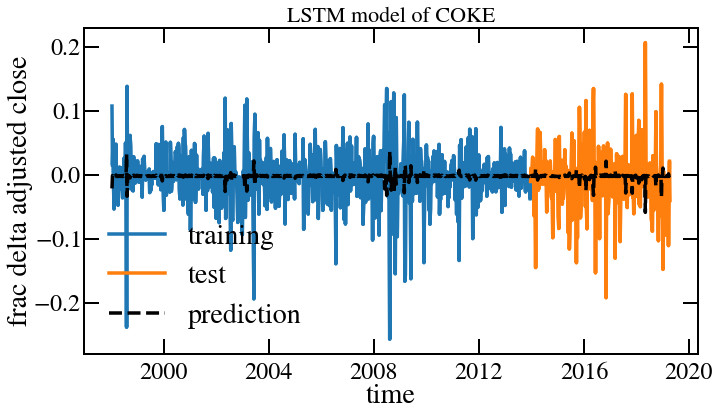

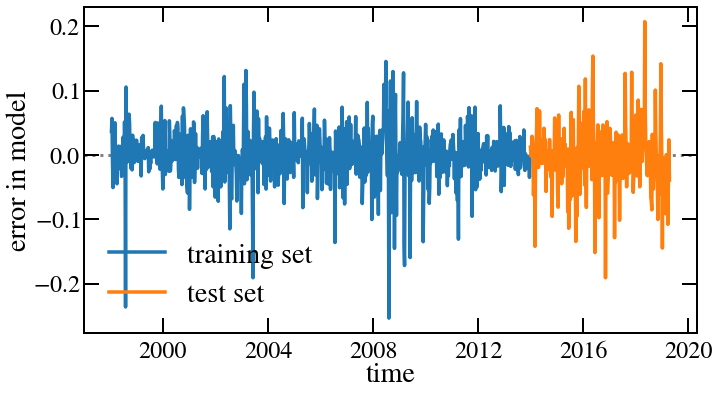

In [37]:
target_key = 'frac delta adjusted close'
model, fig, data = train_lstm_symbol_and_plot(symbol, symbol_list, target_key)
error_fig = plot_errors_lstm(model, data)

So we're maybe doing a little bit better here, but again we're not able to capture the rapid variance.  Let's try doing the raw data again, since that worked well above

###### Version where we train on the raw data first, instead of the differenced data:

training on 832 datapoints w/ 277 as test points
training model...Epoch 00075: early stopping
done!
R2 score for the training set = 	0.957
R2 score for the test set = 	0.972


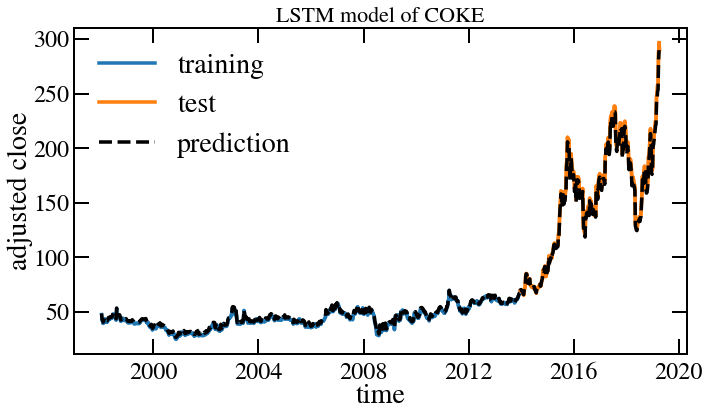

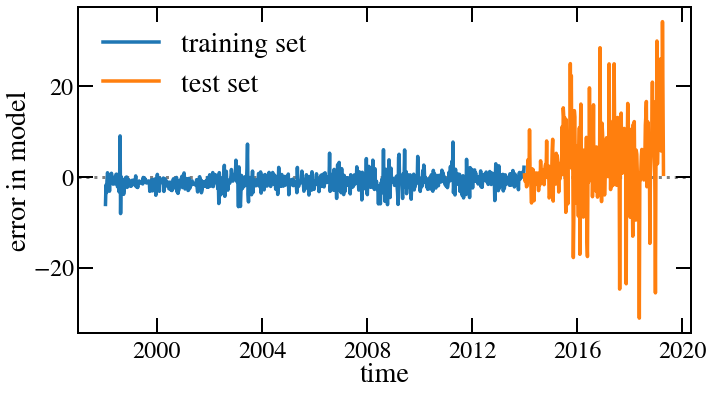

In [38]:
target_key = 'adjusted close'
model, fig, data = train_lstm_symbol_and_plot(symbol, symbol_list, target_key, rescale=False, num_neurons=7)
error_fig = plot_errors_lstm(model, data)

Also pretty good!  Next step would be to compare how the two models perform, but let's also try it on a couple of the symbols that the previous model struggled with:

training on 832 datapoints w/ 276 as test points
training model...Epoch 00010: early stopping
done!
R2 score for the training set = 	0.924
R2 score for the test set = 	0.671


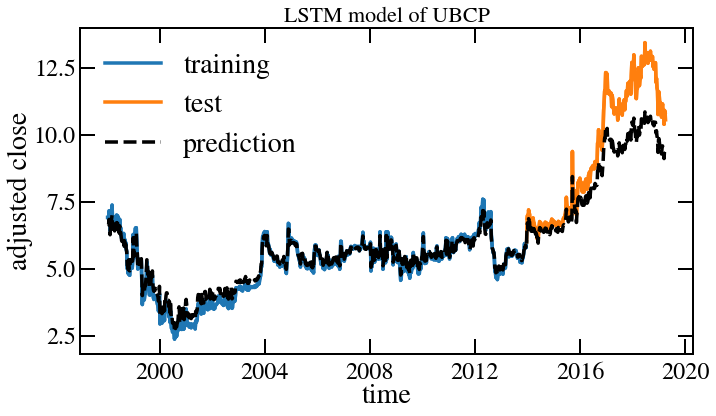

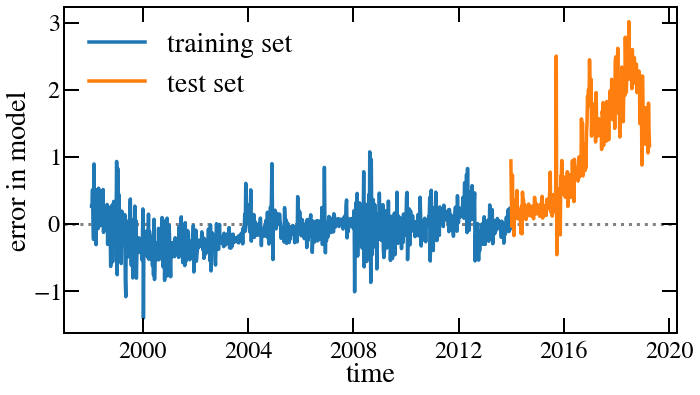

In [39]:
model, fig, data = train_lstm_symbol_and_plot('UBCP', symbol_list, target_key, rescale=False, num_neurons=7)
error_fig = plot_errors_lstm(model, data)

This looks to be doing even worse, as far as I can tell by eye.

### So finally, let's try the LSTM model but using a couple additional time-series values as inputs

In [155]:
symbol = 'COKE'

exog_keys = ['normalized variance', 'frac delta volume']
# exog_keys = []

df = load_symbol_data(symbol, symbol_list, resample=None)

orig_vals = deepcopy(df[target_key])
orig_times = deepcopy(df.index)

training_values, test_values = split_train_test(df, 0.75, target_key, exog_keys=exog_keys)

training_keys = [target_key] + exog_keys

# these are what I want to predict...
training_values['X_1'] = training_values[target_key].shift()
test_values['X_1'] = test_values[target_key].shift()

training_values.dropna(axis='index', inplace=True)
test_values.dropna(axis='index', inplace=True)

X_train = training_values[training_keys].values
y_train = training_values['X_1'].values

X_test = test_values[training_keys].values
y_test = test_values['X_1'].values

X_train_lmse = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lmse = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [156]:
X_train_lmse.shape

(832, 1, 3)

In [157]:
num_neurons = 9

In [158]:
model = Sequential()
model.add(LSTM(num_neurons, 
               batch_input_shape=(1, X_train_lmse.shape[1], X_train_lmse.shape[2]), 
               activation='relu', 
                kernel_initializer='lecun_uniform', 
                return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

history = model.fit(X_train_lmse, y_train, epochs=30, batch_size=1, verbose=1, 
          shuffle=False, callbacks=[early_stop])

Epoch 1/30
832/832 [==============================] - 4s 5ms/step - loss: 2997.3059
Epoch 2/30
832/832 [==============================] - 2s 3ms/step - loss: 1122.6462
Epoch 3/30
832/832 [==============================] - 2s 3ms/step - loss: 27.3191
Epoch 4/30
832/832 [==============================] - 2s 3ms/step - loss: 2.8314
Epoch 5/30
832/832 [==============================] - 2s 2ms/step - loss: 2.8285
Epoch 6/30
832/832 [==============================] - 2s 2ms/step - loss: 2.8222
Epoch 7/30
832/832 [==============================] - 2s 3ms/step - loss: 2.8218
Epoch 8/30
832/832 [==============================] - 2s 2ms/step - loss: 2.8258A: 0s - lo
Epoch 9/30
832/832 [==============================] - 2s 2ms/step - loss: 2.8309
Epoch 10/30
832/832 [==============================] - 2s 2ms/step - loss: 2.8346
Epoch 00010: early stopping


In [159]:
y_train_pred = model.predict(X_train_lmse, batch_size=1).flatten()

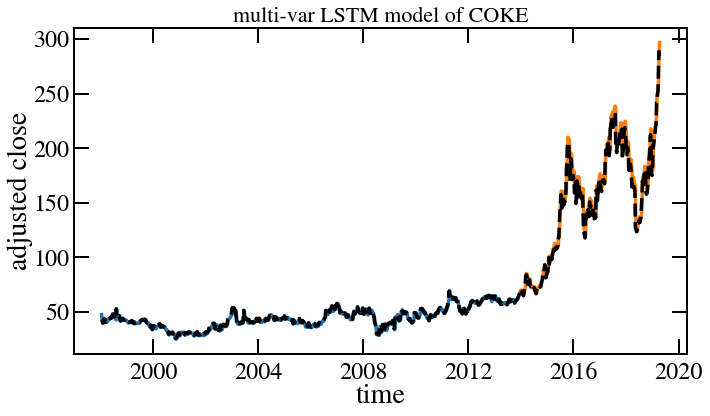

In [160]:
training_times = training_values.index
test_times = test_values.index

fig = plt.figure(figsize=figsize)
ax = plt.gca()

ax.set_title('multi-var LSTM model of {}'.format(symbol), fontsize=22)

l = ax.plot(training_times, y_train, label='training')
# ax.plot(training_times[:-1], X_train_lmse[:,0], label='_nolegend_', color=l[-1].get_color())

l = ax.plot(test_times, y_test, label='test')
# ax.plot(test_times[:-1], X_test.flatten(), label='_nolegend_', color=l[-1].get_color())

ax.set_ylabel(target_key)
ax.set_xlabel('time')

y_train_pred = model.predict(X_train_lmse, batch_size=1).flatten()
y_test_pred = model.predict(X_test_lmse, batch_size=1).flatten()

ax.plot(training_times, y_train_pred, color='k', label='prediction', ls='--')
ax.plot(test_times, y_test_pred, color='k', label='_nolegend_', ls='--')


Hooray!  Unclear if it's actually better though...let's smash this into a function and try on a couple of symbols we again struggled with above:

In [165]:
def train_and_plot_lstm_with_exog(symbol, symbol_list, target_key, exog_keys, 
                                 resample=None, num_neurons=9):

    df = load_symbol_data(symbol, symbol_list, resample=resample)

    orig_vals = deepcopy(df[target_key])
    orig_times = deepcopy(df.index)

    training_values, test_values = split_train_test(df, 0.75, target_key, exog_keys=exog_keys)

    training_keys = [target_key] + exog_keys

    # these are what I want to predict...
    training_values['X_1'] = training_values[target_key].shift()
    test_values['X_1'] = test_values[target_key].shift()

    # basically drop the first and last rows, which have NaNs due to the shift
    training_values.dropna(axis='index', inplace=True)
    test_values.dropna(axis='index', inplace=True)
    
    # times are after the drop, so no need to trim these
    training_times = training_values.index
    test_times = test_values.index

    # training values...
    X_train = training_values[training_keys].values
    
    # training targets
    y_train = training_values['X_1'].values

    # test values
    X_test = test_values[training_keys].values

    # test targets
    y_test = test_values['X_1'].values

    # reshape the training and testing values into tensors
    X_train_lmse = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_lmse = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    ### make the plot:
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()

    ax.set_title('multi-var LSTM model of {}'.format(symbol), fontsize=22)

    l = ax.plot(training_times, y_train, label='training')
    l = ax.plot(test_times, y_test, label='test')

    ax.set_ylabel(target_key)
    ax.set_xlabel('time')

    model = Sequential()
    model.add(LSTM(num_neurons, 
                   batch_input_shape=(1, X_train_lmse.shape[1], X_train_lmse.shape[2]), 
                   activation='relu', 
                   kernel_initializer='lecun_uniform', 
                   return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

    history = model.fit(X_train_lmse, y_train, epochs=30, batch_size=1, verbose=1, 
              shuffle=False, callbacks=[early_stop])
    
    # get the model predictions as flat arrays
    y_train_pred = model.predict(X_train_lmse, batch_size=1).flatten()
    y_test_pred = model.predict(X_test_lmse, batch_size=1).flatten()

    # plot the model predictions
    ax.plot(training_times, y_train_pred, color='k', label='prediction', ls='--')
    ax.plot(test_times, y_test_pred, color='k', label='_nolegend_', ls='--')
    
    ax.legend()

     ### plot the errors in the predictions:
    error_fig = plt.figure(figsize=figsize)
    error_ax = plt.gca()

    train_error = y_train.flatten() - y_train_pred
    test_error = y_test.flatten() - y_test_pred

    error_ax.plot(training_times, train_error, label='training set')
    error_ax.plot(test_times, test_error, label='test set')

    error_ax.axhline(y=0, ls=':', color='grey', lw=3, zorder=0, label='_nolegend_')
    error_ax.set_xlabel('time')
    error_ax.set_ylabel('error in model')

    error_ax.legend()
    return model, fig, error_fig

Epoch 1/30
832/832 [==============================] - 6s 7ms/step - loss: 157.1382
Epoch 2/30
832/832 [==============================] - 2s 3ms/step - loss: 2.9698
Epoch 3/30
832/832 [==============================] - 2s 3ms/step - loss: 2.9581
Epoch 4/30
832/832 [==============================] - 2s 3ms/step - loss: 2.9407
Epoch 5/30
832/832 [==============================] - 2s 3ms/step - loss: 2.9204
Epoch 6/30
832/832 [==============================] - 2s 3ms/step - loss: 2.9007
Epoch 7/30
832/832 [==============================] - 2s 3ms/step - loss: 2.8846
Epoch 8/30
832/832 [==============================] - 2s 3ms/step - loss: 2.8733
Epoch 9/30
832/832 [==============================] - 2s 2ms/step - loss: 2.8663
Epoch 10/30
832/832 [==============================] - 2s 3ms/step - loss: 2.8625
Epoch 11/30
832/832 [==============================] - 2s 3ms/step - loss: 2.8605
Epoch 12/30
832/832 [==============================] - 2s 3ms/step - loss: 2.8595
Epoch 13/30
832/832 [==

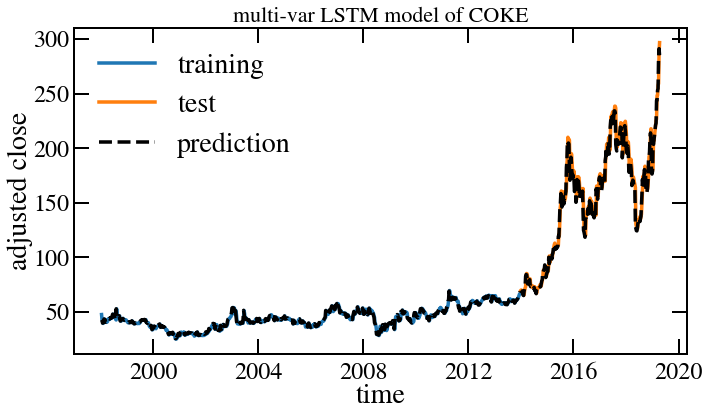

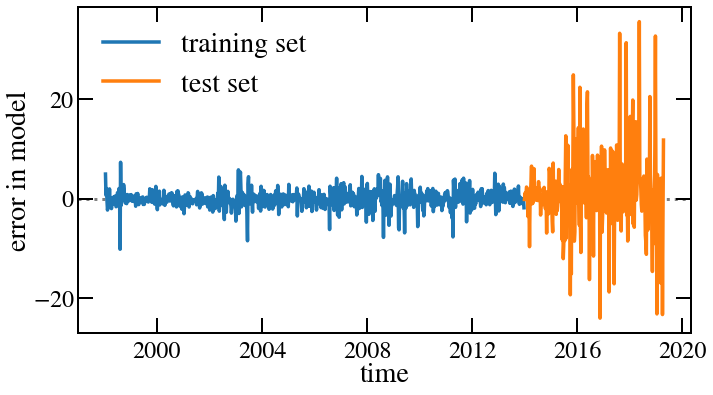

In [170]:
target_key = 'adjusted close'
exog_keys = ['normalized variance', 'frac delta volume']
model, fig, error_fig = train_and_plot_lstm_with_exog('COKE', symbol_list, target_key, exog_keys)

Epoch 1/30
832/832 [==============================] - 5s 7ms/step - loss: 700.4796
Epoch 2/30
832/832 [==============================] - 2s 2ms/step - loss: 3.0651
Epoch 3/30
832/832 [==============================] - 2s 3ms/step - loss: 3.0168
Epoch 4/30
832/832 [==============================] - 2s 2ms/step - loss: 2.9690
Epoch 5/30
832/832 [==============================] - 2s 2ms/step - loss: 2.9311
Epoch 6/30
832/832 [==============================] - 2s 2ms/step - loss: 2.9041
Epoch 7/30
832/832 [==============================] - 2s 2ms/step - loss: 2.8868
Epoch 8/30
832/832 [==============================] - 2s 2ms/step - loss: 2.8773
Epoch 9/30
832/832 [==============================] - 2s 2ms/step - loss: 2.8728
Epoch 10/30
832/832 [==============================] - 2s 3ms/step - loss: 2.8710
Epoch 11/30
832/832 [==============================] - 2s 3ms/step - loss: 2.8702
Epoch 12/30
832/832 [==============================] - 2s 3ms/step - loss: 2.8698
Epoch 13/30
832/832 [==

KeyboardInterrupt: 

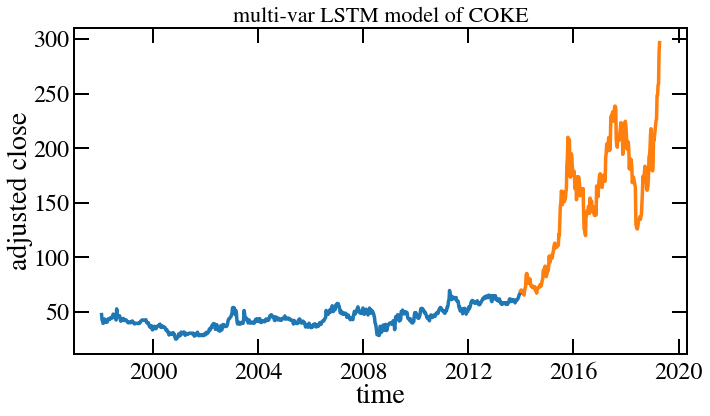

In [171]:
model, fig, error_fig = train_and_plot_lstm_with_exog('COKE', symbol_list, target_key, exog_keys, num_neurons=11)

Epoch 1/30
832/832 [==============================] - 5s 6ms/step - loss: 146.6654
Epoch 2/30
832/832 [==============================] - 2s 3ms/step - loss: 3.3928
Epoch 3/30
832/832 [==============================] - 2s 3ms/step - loss: 3.2059
Epoch 4/30
832/832 [==============================] - 2s 3ms/step - loss: 3.0879
Epoch 5/30
832/832 [==============================] - 2s 3ms/step - loss: 3.0188
Epoch 6/30
832/832 [==============================] - 2s 2ms/step - loss: 2.9852
Epoch 7/30
832/832 [==============================] - 2s 3ms/step - loss: 2.9667
Epoch 8/30
832/832 [==============================] - 2s 2ms/step - loss: 2.9522
Epoch 9/30
832/832 [==============================] - 2s 2ms/step - loss: 2.9405
Epoch 10/30
832/832 [==============================] - 2s 2ms/step - loss: 2.9345
Epoch 11/30
832/832 [==============================] - 2s 2ms/step - loss: 2.9272
Epoch 12/30
832/832 [==============================] - 2s 3ms/step - loss: 2.9234
Epoch 13/30
832/832 [==

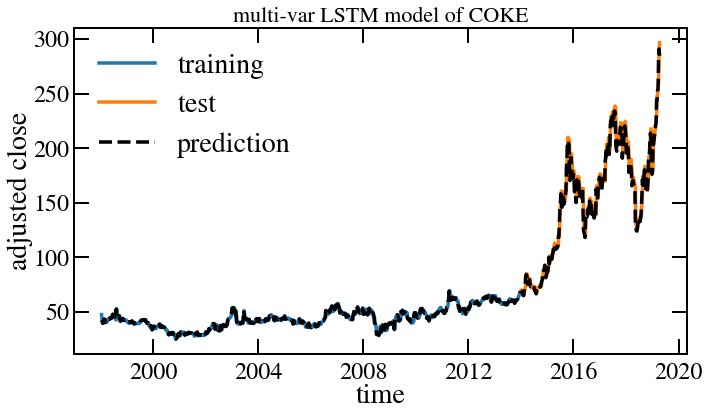

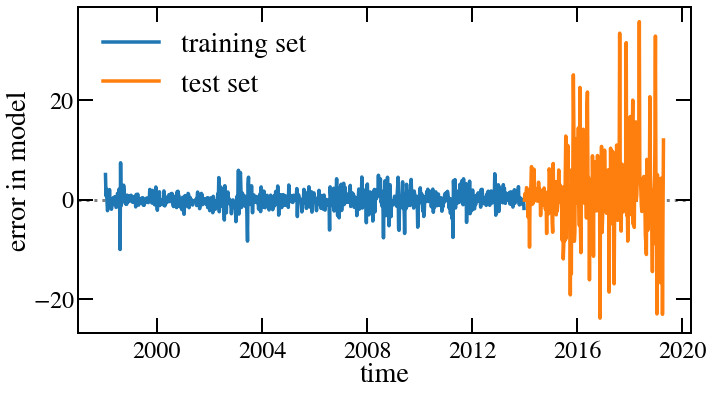

In [167]:
model, fig, error_fig = train_and_plot_lstm_with_exog('COKE', symbol_list, target_key, exog_keys, num_neurons=21)

Epoch 1/30
832/832 [==============================] - 7s 8ms/step - loss: 2053.7993
Epoch 2/30
832/832 [==============================] - 2s 2ms/step - loss: 1979.4790
Epoch 3/30
832/832 [==============================] - 2s 2ms/step - loss: 1909.5770
Epoch 4/30
832/832 [==============================] - 2s 2ms/step - loss: 1841.7266
Epoch 5/30
832/832 [==============================] - 2s 2ms/step - loss: 1775.5267
Epoch 6/30
832/832 [==============================] - 2s 3ms/step - loss: 1710.8180
Epoch 7/30
832/832 [==============================] - 2s 3ms/step - loss: 1647.5253
Epoch 8/30
832/832 [==============================] - 2s 3ms/step - loss: 1585.6115
Epoch 9/30
832/832 [==============================] - 2s 2ms/step - loss: 1525.0570
Epoch 10/30
832/832 [==============================] - 2s 2ms/step - loss: 1465.8510
Epoch 11/30
832/832 [==============================] - 2s 2ms/step - loss: 1407.9879
Epoch 12/30
832/832 [==============================] - 2s 2ms/step - loss:

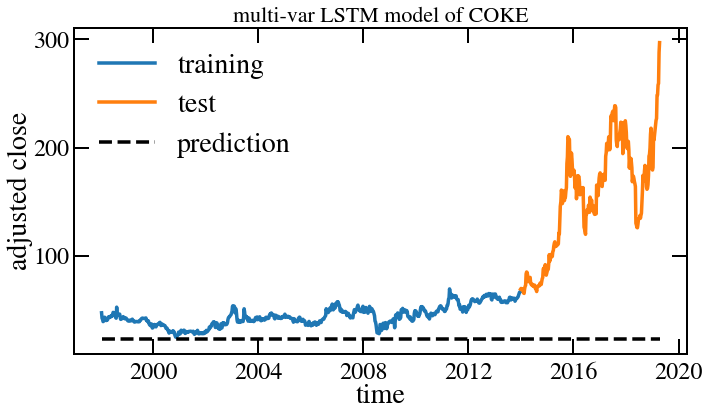

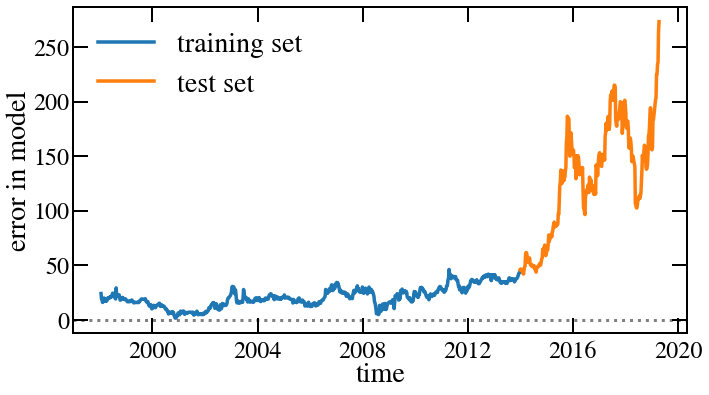

In [168]:
model, fig, error_fig = train_and_plot_lstm_with_exog('COKE', symbol_list, target_key, exog_keys, num_neurons=3)

OK, so that seems like too few neurons (could maybe overcome it with more epochs, but seems like a bad trade)

Epoch 1/30
832/832 [==============================] - 6s 7ms/step - loss: 4.1941
Epoch 2/30
832/832 [==============================] - 2s 3ms/step - loss: 0.5215
Epoch 3/30
832/832 [==============================] - 2s 3ms/step - loss: 0.4903
Epoch 4/30
832/832 [==============================] - 2s 3ms/step - loss: 0.4673
Epoch 5/30
832/832 [==============================] - 2s 3ms/step - loss: 0.4528
Epoch 6/30
832/832 [==============================] - 2s 3ms/step - loss: 0.4429
Epoch 7/30
832/832 [==============================] - 2s 3ms/step - loss: 0.4369
Epoch 8/30
832/832 [==============================] - 2s 3ms/step - loss: 0.4313
Epoch 9/30
832/832 [==============================] - 2s 3ms/step - loss: 0.4284
Epoch 10/30
832/832 [==============================] - 2s 3ms/step - loss: 0.4244
Epoch 11/30
832/832 [==============================] - 2s 3ms/step - loss: 0.4228
Epoch 12/30
832/832 [==============================] - 2s 3ms/step - loss: 0.4207
Epoch 13/30
832/832 [====

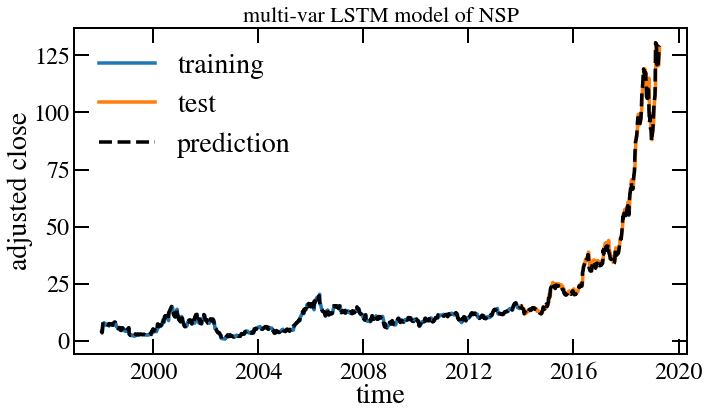

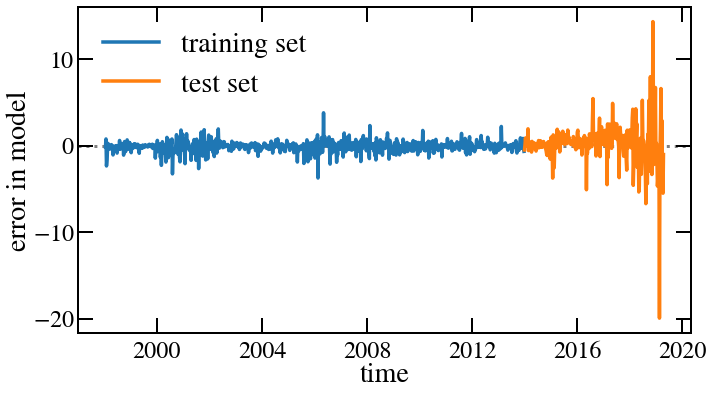

In [173]:
model, fig, error_fig = train_and_plot_lstm_with_exog('NSP', symbol_list, target_key, exog_keys, num_neurons=21)

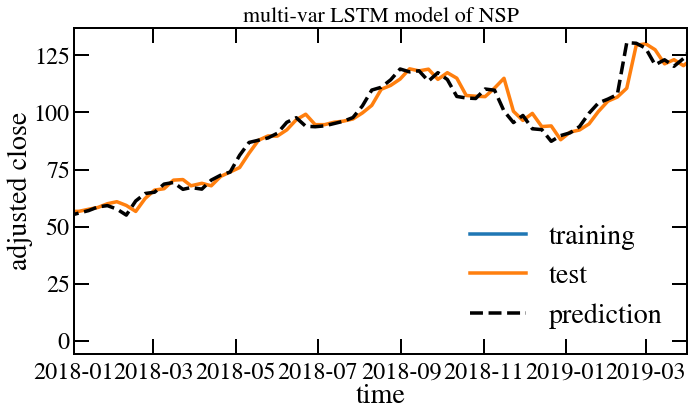

In [178]:
xlim = [datetime.date(2018, 1, 1), datetime.date(2019, 4, 1)]
fig.axes[0].set_xlim(xlim)
fig

Importantly, the prediction isn't just trailing the actual value by one timestep -- it actually preceeds it sometimes!

#### Some debugging for the multi-var LSTM model

training multi-var LSTM model...Epoch 00003: early stopping
done!


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1195ecf28> (for post_execute):


ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

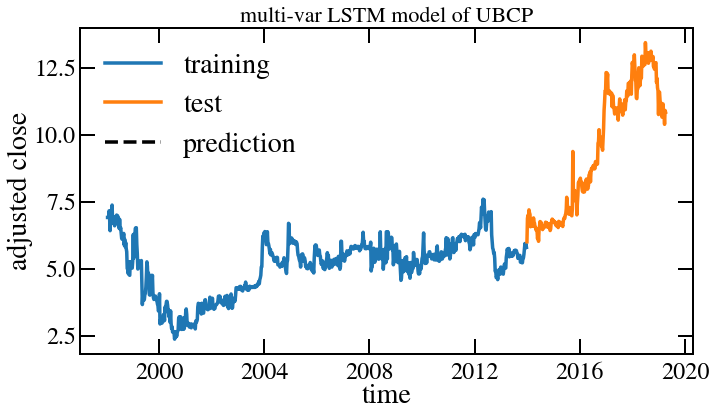

ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 792x432 with 1 Axes>

In [145]:
target_key = 'adjusted close'
exog_keys = ['normalized variance', 'frac delta volume']
# model, fig, error_fig = train_and_plot_lstm_with_exog('UBCP', symbol_list, target_key, exog_keys)

symbol = 'UBCP'
resample=None
num_neurons=9

df = load_symbol_data(symbol, symbol_list, resample=resample)

orig_vals = deepcopy(df[target_key])
orig_times = deepcopy(df.index)

training_values, test_values = split_train_test(df, 0.75, target_key, exog_keys=exog_keys)

training_keys = [target_key] + exog_keys

# these are what I want to predict...
training_values['X_1'] = training_values[target_key].shift()
test_values['X_1'] = test_values[target_key].shift()

# basically drop the first and last rows, which have NaNs due to the shift
training_values.dropna(axis='index', inplace=True)
test_values.dropna(axis='index', inplace=True)

# times are after the drop, so no need to trim these
training_times = training_values.index
test_times = test_values.index

# training values...
X_train = training_values[training_keys].values

# training targets
y_train = training_values['X_1'].values

# test values
X_test = test_values[training_keys].values

# test targets
y_test = test_values['X_1'].values

# reshape the training and testing values into tensors
X_train_lmse = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lmse = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

### make the plot:
fig = plt.figure(figsize=figsize)
ax = plt.gca()

ax.set_title('multi-var LSTM model of {}'.format(symbol), fontsize=22)

l = ax.plot(training_times, y_train, label='training')
l = ax.plot(test_times, y_test, label='test')

ax.set_ylabel(target_key)
ax.set_xlabel('time')

### now build and train the model:
model = Sequential()
model.add(LSTM(num_neurons, 
               batch_input_shape=(1, X_train_lmse.shape[1], X_train_lmse.shape[2]), 
               activation='relu', 
               kernel_initializer='lecun_uniform', 
               return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

print("training multi-var LSTM model...", end='')
history = model.fit(X_train_lmse, y_train, epochs=30, batch_size=1, verbose=0, 
          shuffle=False, callbacks=[early_stop])
print("done!")

# get the model predictions as flat arrays
y_train_pred = model.predict(X_train_lmse, batch_size=1).flatten()
y_test_pred = model.predict(X_test_lmse, batch_size=1).flatten()

# plot the model predictions
ax.plot(training_times, y_train_pred, color='k', label='prediction', ls='--')
ax.plot(test_times, y_test_pred, color='k', label='_nolegend_', ls='--')

ax.legend()

#     ### plot the errors in the predictions:
error_fig = plt.figure(figsize=figsize)
error_ax = plt.gca()

train_error = y_train.flatten() - y_train_pred
test_error = y_test.flatten() - y_test_pred

error_ax.plot(training_times, train_error, label='training set')
error_ax.plot(test_times, test_error, label='test set')

error_ax.axhline(y=0, ls=':', color='grey', lw=3, zorder=0, label='_nolegend_')
error_ax.set_xlabel('time')
error_ax.set_ylabel('error in model')

error_ax.legend()

In [ ]:
def train_lstm_with_exog(symbol, target_key, exog_keys, 
                         training_frac=0.75, resample=None, 
                         num_neurons=20):
    
    df = load_symbol_data(symbol, symbol_list, resample=resample)
    training_values, test_values, training_exogs, test_exogs = split_train_test(
        df, training_frac, target_key, exog_keys=exog_keys)

    training_values['X_1'] = training_values[target_key].shift()
    test_values['X_1'] = test_values[target_key].shift()

    # drop the rows that don't have data because we shifted them away
    X_train = training_values.dropna().drop(target_key, axis=1)
    y_train = training_values.dropna().drop('X_1', axis=1)

    X_test = test_values.dropna().drop(target_key, axis=1)
    y_test = test_values.dropna().drop('X_1', axis=1)

    # convert these to matrices
    X_train = X_train.as_matrix()
    y_train = y_train.as_matrix()

    X_test = X_test.as_matrix()
    y_test = y_test.as_matrix()

    # reshape into tensors
    X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    lstm_model = Sequential()
    lstm_model.add(LSTM(num_neurons, 
                        input_shape=(1, X_train_lmse.shape[1]), 
                        activation='relu', 
                        kernel_initializer='lecun_uniform', 
                        return_sequences=False))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    history_lstm_model = lstm_model.fit(X_train_lmse, 
                                        y_train, 
                                        epochs=100, 
                                        batch_size=1, verbose=1, 
                                        shuffle=False, 
                                        callbacks=[early_stop])
    
    return lstm_model, training_values, test_values



# Exploring I did with modeling different parameters and with other networks

#### Finally, we can try doing this on the raw data (rather than the differenced data).  It's not stationary, so my guess is that we'll just get a lagged version of the data, but who knows?

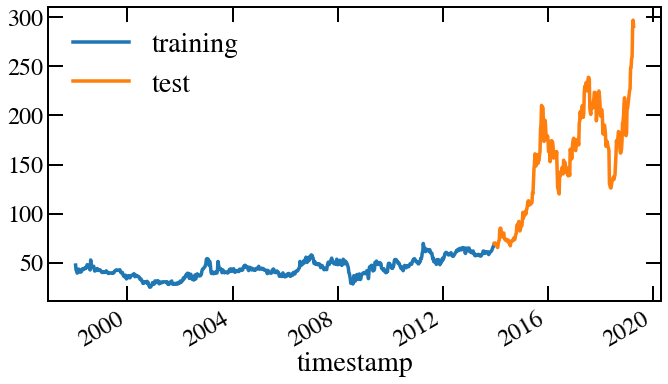

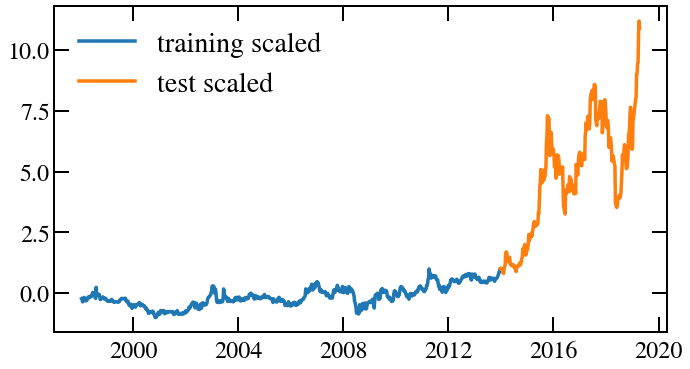

In [90]:
target_key = 'adjusted close'
rtraining_values, rtest_values = split_train_test(output, 0.75, target_key)

fig = plt.figure(figsize=figsize)
ax = plt.gca()

rtraining_values.plot(y=target_key, ax=ax, label='training')
rtest_values.plot(y=target_key, ax=ax, label='test')
ax.legend()

rtraining_scaled = scaler.fit_transform(rtraining_values)
rtest_scaled = scaler.transform(rtest_values)

# ## debug -- not actually scaled -- but doesn't help
# straining_scaled = straining_values[target_key].values
# stest_scaled = stest_values[target_key].values

rtraining_times = rtraining_values.index
rtest_times = rtest_values.index

rX_train = rtraining_scaled[:-1]
ry_train = rtraining_scaled[1:]
rX_test = rtest_scaled[:-1]
ry_test = rtest_scaled[1:]

fig = plt.figure(figsize=figsize)
ax = plt.gca()
ax.plot(rtraining_times[1:], ry_train.flatten(), label='training scaled')
ax.plot(rtest_times[1:], ry_test.flatten(), label='test scaled')
ax.legend()

In [91]:
model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# and train the model!
history = model.fit(rX_train, ry_train, epochs=100, batch_size=1, 
                       verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
832/832 [==============================] - 1s 2ms/step - loss: 0.0561
Epoch 2/100
832/832 [==============================] - 1s 944us/step - loss: 0.0102
Epoch 3/100
832/832 [==============================] - 1s 932us/step - loss: 0.0082
Epoch 4/100
832/832 [==============================] - 1s 925us/step - loss: 0.0072
Epoch 5/100
832/832 [==============================] - 1s 874us/step - loss: 0.0069
Epoch 6/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0067
Epoch 7/100
832/832 [==============================] - 1s 901us/step - loss: 0.0065
Epoch 8/100
832/832 [==============================] - 1s 857us/step - loss: 0.0064
Epoch 9/100
832/832 [==============================] - 1s 819us/step - loss: 0.0063
Epoch 10/100
832/832 [==============================] - 1s 812us/step - loss: 0.0063
Epoch 11/100
832/832 [==============================] - 1s 894us/step - loss: 0.0062
Epoch 12/100
832/832 [==============================] - 1s 881us/step - loss: 

R2 score for the training set =	 0.935
R2 score for the test set is = 	0.424


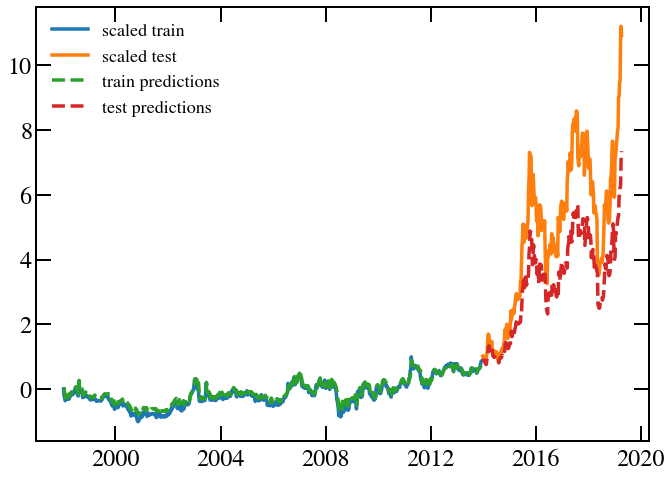

In [94]:
ry_pred_test = model.predict(rX_test)
ry_train_pred = model.predict(rX_train)
print("R2 score for the training set =\t {:0.3f}".format(r2_score(ry_train, ry_train_pred)))
print("R2 score for the test set is = \t{:0.3f}".format(r2_score(ry_test, ry_pred_test)))

fig = plt.figure(figsize=(11, 8))
ax = plt.gca()

# training_values.plot(y=target_key, ax=ax)
ax.plot(rtraining_times[:-1], rX_train.flatten(), label='scaled train')
ax.plot(rtest_times[1:], ry_test.flatten(), label='scaled test')
ax.plot(rtraining_times[1:], ry_train_pred.flatten(), label='train predictions', ls='--')
ax.plot(rtest_times[1:], ry_pred_test.flatten(), label='test predictions', ls='--')

ax.legend(fontsize=18)

Wow, that actually appears to be doing quite well, but let's try zooming in...

(736330.0, 736695.0)

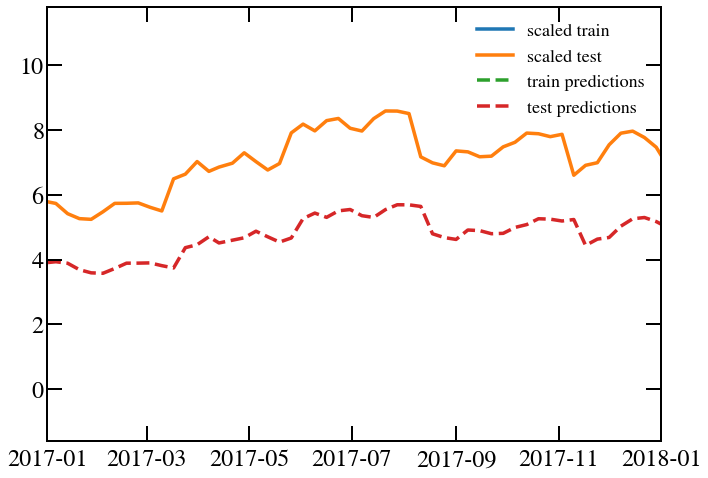

In [93]:
fig = plt.figure(figsize=(11, 8))
ax = plt.gca()

# training_values.plot(y=target_key, ax=ax)
ax.plot(rtraining_times[:-1], rX_train.flatten(), label='scaled train')
ax.plot(rtest_times[1:], ry_test.flatten(), label='scaled test')
ax.plot(rtraining_times[1:], ry_train_pred.flatten(), label='train predictions', ls='--')
ax.plot(rtest_times[1:], ry_pred_test.flatten(), label='test predictions', ls='--')

ax.legend(fontsize=18)

xlim = [datetime.date(2017, 1, 1), datetime.date(2018, 1, 1)]
ax.set_xlim(xlim)

And we can see that we're actually still doing quite poorly because the prediction is just the model but a few days behind -- that's not exactly useful to us!  It means we'll miss the boat on every transaction.

So, still doing really poorly, so let's try a more advanced model -- an LSTM RNN

### Some exploring I was doing with VARMAX; not completed because it doesn't seem like the right tool for the job

Have to decide what order I want to use... (i.e. how many immediately preceeding terms I want the model to look at). Let's look at the partial autocorrelation function to get a sense of what it seems to depend on.

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

fig = plt.figure(figsize=figsize)
ax = plt.gca()
fig = plot_pacf(output['frac delta close'], ax=ax)

Hmm, so in this case at least, the only correlation is actually on very long timescales, which suggests it may not be a great dataset for this type of time-series forecasting -- let's see if there's *any* on shorter scales that I can exploit though.

In [ ]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
fig = plot_pacf(output['frac delta close'], ax=ax, lags=range(1, 15))

So there's not a lot, but there is some power in 2, 3, and 11, in roughly that order...

Let's make this a bit more rigorous by doing a grid search.  VARMAX's order is (p, q) where p is the trend autoregression order and q is the trend moving average order.

In [ ]:
model = VARMAX(output['frac delta close'], exog=[
    output['frac delta volume'], output['normalized variance']],
    order=)